# Ordinary Differential Equation Solver "Odie:" a Tutorial

## Authors: Gabriel M Steward

### January 2023

https://github.com/zachetienne/nrpytutorial/blob/master/Tutorial-Template_Style_Guide.ipynb

Link to the Style Guide. Not internal in case something breaks. 

### </list_source_code> NRPy+ Source Code for this module:
[RK_Butcher_Table_Dictionary.py](/edit/RK_Butcher_Table_Dictionary.py)

[cmdline_helper.py](/edit/cmdline_helper.py)

[outputC.py](/edit/outputC.py)

## Introduction:
Welcome to the Ordinary Differential Equation Solver Tutorial notebook, wherin we will both showcase a program that solves Ordinary Differential Equations and instruct users on how to use it for their own projects. 

This Ordinary Differential Equation Solver, affectionately known as "Odie," takes a system of Ordinary Differential Equations (ODEs) with initial boundary conditions and solves it numerically, the result being a text file with the previously unknown functions' values. The code is generic and can use any Runge Kutta-style method to solve the ODE. 15 different options ranging from first to eighth order are avialable within this notebook, and if the user has a butcher table that defines a unique method, it can be inserted manually. In addition, the program supports an internal validation check which checks the initial order of the error, so long as a known solution is provided--but this is not necessary for the program to operate.

This code is still a work in progress. In the future we intend to give it adaptable time-step functionality. 

The user can specify a few values in the Customization section ([Step 2a](#S2a) below): the method used to solve the ODE, the step size, and how many steps to take. If the function needs to be changed the code itself has to be altered, but for most equations this won't be difficult, and one of the purposes of this notebook is to instruct users on how exactly to do that.  

## </other>  Other:
A note: this notebook attempts to be a proper tutorial, but it is under construction, so suggestions are welcome. 

### Note on Notation:
Any new notation will be brought up in the notebook when it becomes relevant. 

### Citations:

Matplotlib documentation. (Needs no citation?) 

<a id='1'></a>
[1] https://en.wikibooks.org/wiki/C_Programming/time.h (Using time.h)

<a id='2'></a>
[2] https://askubuntu.com/questions/332884/how-to-compile-a-c-program-that-uses-math-h (math.h compilation requirements)

<a id='3'></a>
[3] https://www.tutorialspoint.com/cprogramming/c_file_io.htm (Basic file operations)

<a id='4'></a>
[4] Numerical Mathematics and Computing 6E by Cheney and Kincaid (Primary Text)

<a id='5'></a>
[5] NRPy+ "Solving the Scalar Wave Equation" (Plotting code, surprisingly)

<a id='6'></a>
[6] https://www.dataquest.io/blog/read-file-python/ (Opening and reading CSV files)

<a id='7'></a>
[7] https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib (Changing size of plot)

<a id='8'></a>
[8] https://stackoverflow.com/questions/37538/how-do-i-determine-the-size-of-my-array-in-c (Need to determine what we are being handed by the butcher tables.)

<a id='9'></a>
[9] https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine (how to move up out of a Python directory.)

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

1. [Step 1:](#S1) Background: The Problem Statement

    2. [Step 1a:](#S1a) Validation Method

3. [Step 2:](#S2) The Code

3. [Step 3:](#S3) Simple Problem Example

    4. [Step 3a:](#S3a) Simple Problem Customization

    4. [Step 3b:](#S3b) Simple Problem Python-Code

    5. [Step 3c:](#S3c) Simple Problem C-Code

    6. [Step 3d:](#S3d) Simple Problem Results
    
    6. [Step 3e:](#S3e) Simple Problem Analysis
        
    6. [Step 3f:](#S3f) Multiple Run Examination
    
7. [Step 4:](#S4) Complicated Problem Example

    4. [Step 4a:](#S4a) Complicated Problem Customization

    4. [Step 4b:](#S4b) Complicated Problem Python-Code

    5. [Step 4c:](#S4c) Complicated Problem C-Code

    6. [Step 4d:](#S4d) Complicated Problem Results
    
    6. [Step 4e:](#S4e) Complicated Problem Analysis

7. [Step 5:](#S5) User-Defined Problem Section

    4. [Step 4a:](#S5a) Customization

    4. [Step 4b:](#S5b) Python-Code

    5. [Step 4c:](#S5c) C-Code

    6. [Step 4d:](#S5d) Results
    
    6. [Step 4e:](#S5e) Analysis

8. [Step 6:](#S6) Conclusion

8. [Step 7:](#S7) Questions/Ecercies(?)

9. [Step 8:](#S8) Output this notebook to $\LaTeX$-formatted PDF file

<a id='S1'></a>

# Step 1: Background: The Problem Statement \[Back to [top](#toc)\]
$$\label{S1}$$

#### In order to solve a problem, one must first know the problem exists.

Before we get into the code and instruct potential users on how to use it, we first need to specify exactly what sorts of problems it can solve. 

This program seeks to take a system of Ordinary Differential Equations and solve it. To be clear, an Ordinary Differential Equation is an equation relating a function and its derivatives together, with the requirement that all derivatives be taken with respect to a single variable. If multiple variable derivatives are involved, it becoems a Partial Differential Equation. While the program only solves systems of first-order ODEs, every higher-order ODE can be split up into a system of first-order ODEs, thus the program can solve any order ODE so long as the user splits it up into a system first, which is always possible for ODEs. 

Mathematically, our solver can solve equations of the form:

$$ \frac{dy(x)}{dx} = f(x,y(x)) ; \text{ given } y(a)=b$$

Where a system would take the form:

$$ \frac{dy_n(x)}{dx} = f(x,y_n(x)) ; \text{ given } y_n(a)=b_n$$

Where $f$ is some function that does not contain any derivative or integral operators. A solution is to find what the function $y(x)$ actually is. The given $y_n(a)=b_n$ are the boundary conditions for this problem. For this solver we start at the point $a$ and increase it over time, treating $a$ as the start of an "initial condition." 

The program will restrict itself to Runge-Kutta type solution methods, which take an initial condition and evolve it forward in "time" with various relational methods, all of which are based in the Taylor Series Expansion. The specifics of these methods can be found elsewhere ([here](https://nbviewer.org/github/zachetienne/nrpytutorial/blob/master/Tutorial-RK_Butcher_Table_Dictionary.ipynb)). The basic idea is that one value is used to calculate another value forward in "time," and this new value can be used to find the next one, and so on and so forth. Since we start with an initial condition, we can always use such methods. 

<a id='S1a'></a>

## Step 1a: Validation Method \[Back to [top](#toc)\]
$$\label{S1a}$$

#### A program is worse than useless if it doesn't work and you don't know it.

An important part of simulation codes is validation--does the program do what we expect it to do when presented with known data? Granted, oftentimes we simply do not know what we are looking for and have nothing to compare against. However, as this is a general ODE Solver, it can be put to the task of solving problems with well-known answers, and we can compare the program's solution with the real solution to determine if it is working. 

When the closed-form answer to a problem is known, it can be inserted into the program, and the program will attempt to find the order of the error. Every method we use has an associated error term with it, $\mathcal{O}(h^m)$ where $m$ is some integer that indicates the order of the error term. A first-order method would have $m=2$ since the method accurately represents terms up to $m=1$, and then the error is $m=2$. In other words, a method of a certain order gets everything right up to that order, but not beyond it.

At the moment, we are concerned with the error with respect to the step size, which is how far in "time" we evolve the solution with every calculation. The question is, how exactly do we determine the order of a method from the data alone? 

To start, we can extract the error with the rather simple relation 

$$ \text{Truth} - \text{Calculation} = \text{Error} = \mathcal O(h^m) $$

Now, O-notation is somewhat ambiguous, for we do not know how large the term it represents is, and there can be terms of order higher than $m$ that are supressed. If we assume that the $m$-order term dominates all the others, then we can write out

$$ E \approx Ah^m,$$

where $E$ is error, $A$ is some unknown constant, $h$ is the step size, and $m$ is the order. 

Let us say that we were to perform this error calculation twice: once for some unknown step value $h$, and once for precisely half, $h/2$. This would produce two different error values. 

$$ E_1 = Ah^m; E_2 = A \frac{h^m}{2^m}$$

We can solve both of these equaitons for $A$, which is the same in both.

$$ A = \frac{E_2}{h^m / 2^m} = \frac{E_1}{h^m} $$

From here we can just solve for $m$.

$$ \Rightarrow \frac{E_2}{E_1} = \frac{1}{2^m} $$
$$ \Rightarrow \frac{E_1}{E_2} = 2^m $$
$$ \Rightarrow m = log_2 \frac{E_1}{E_2} $$

Keep in mind that $m$ is the order of the error term, the actual order of the method used would be $m-1$ in this case. So a first-order method would have $m=2$. Also be careful to keep the "1" and "2" subscripts on the errors in the right sequence; the $E_2$ term comes from the halved step size. 

This method is very convenient for a few reasons. For one, it doesn't require any Taylor Series terms or any inputs aside from the first error terms of two separate calculations. In addition, the errors should be taken from the *first* step which means it isn't necessary to perform the calculations for the entire ODE twice just to get an order estimate. 

It does have a rather major failing though, and that comes with its primary assumption: that the errors are dominated by a single term. This need not be the case and often changes based on the step size. The other higher-order error terms do influence the result, and they can do it in unexpected ways, and as such the result $m$ will rarely, if ever, actually be an integer. However, as we know it *should* be an integer, if we round the number all the problems from the other terms will usually go away, though not always. Fortuantely, as this validation is largely for the method itself and not the answer, it's always possible to just insert a different more well-behaved function for validation. Higher order methods break this validation check more often than lower order methods, since higher order methods regularly hit roundoff error at low step sizes, larger step sizes are required to get actual error--and larger step sizes mean the relative differences between terms gets smaller. 0.1 reduces things by a factor of ten, which is regularly overruled by the leading cosntant, but 0.01's hundredth tends to win out. So it's very context dependent! 

There is a quirk that occurs if the Taylor Series Expansion of a solution is missing terms (or is finite). Say, for instance, the $m=3$ term was missing and we had an order 2 solver. Well, the order detector expects to find $m=3$, but instead it finds $m=4$ since there isn't any $m=3$ error term to find. This is not a problem, it is perfectly fine for a method to have an order *higher* than expected. Lower is when there would be a problem. Similar issues occur if the soluiton is exact or near exact, in which case the validation will claim the error order is infinite. 

This naieve validation does not fulfill our complete needs to check the code, for that we need to compare the results with those from a trusted solver for a specific system of ODEs. In one of our examples we solve a set of equations known as the TOV equations and compare it with trusted data for further validation. 

Now that we have our tools, we are prepared to look at the actual program. 

<a id='S2'></a>

# Step 2: The Code \[Back to [top](#toc)\]
$$\label{S2}$$

#### Odie is our friend, but do we understand our friend?

Before looking at the code itself, lets first discuss how it operates. Prior to running the code, it is important to know that the user can manually set certain things in the code itself. Within the funciton `diffyQEval` lies the definition of the differential equations that make up the system of ODEs. We have several examples set up to demonstrate how a user can cusotmize these functions. `diffyQEval` takes three arguments: `x`, `y`, and `c`. `x` is a number that describes position, usually thought of as "time" but it could easily be "radius" or just "distance." `y` is an array that contains values for each equation in the system that will be used to evaluate the differential equaitons at point `x`. `c` is an array that holds constants, and is not always used, but sometimes there are quantities we wish to track that are related to the system of ODEs but not explicitly evaluated as an ODE.  

`getInitialConditions` is a function that does exactly what it says: it takes an array `y` and fills it with the initial conditions specified within. The user is expected to provide these conditions, one for each differential equation.

`constEval` is similar to `diffyQEval` except it doesn't evaluate derivatives, it just calculates what the constants in `c` should be based on the values passed in `y`. This function may be entirely empty in certain implementaitons. 

`knownQeval` is only used when we wish to run validation checks against a known equation, in which case it contains the solutions to the differential equations. It is passed `x` and `y`, evaluating each solution at the given points and returning `y` with the adjusted values. 

`doWeTerminate` is another optional function. It takes in `x`, `y`, and `c`. The user is able to specify any sort of check imaginable on these parameters, and if the check triggers, the function returns 1, indicating that the program a as a whole should stop. This could be used to abort if the program hits a well-known error, or if a user doesn't know precisely how many steps to take but do know how big a variable should get before termination. 

`exceptionHandler`is another optional function, different from the prior in that it doesn't just perform a check, it changes data passed to it. It takes in `x`, `y`, and `c`, examining them for any condition the user can think of. If a condition is found, it will modify the data passed to it. Say, for instance, we have a differential equation with a square root in it, but the value within is very close to zero several times during evaluation. An estimation method may accidentially dip into negative numbers, and the square root of a negative number will result in NaN results. The exceptionHandler can see this negative value ahead of time and set it to zero to ensure calculation still goes smoothly. 

There are a set of mutable parameters that determine how the simulation is run, both of which can be set within this notebook in the Customization section ([Step 2a](#S2a) below). `step` is the step size. Smaller `step` numbers mean better accuracy generally. `bound` is the value we start evaluating from--be it $t=0$, $x=1$, or $r=3.14159$, it can be anything real. `SIZE` is how large the area we're solving for is. We start at `bound`, but `SIZE` determines where we end.

In addition, the method can also be chosen by setting `key` to one of the many options for solving methods, which are listed in the Customization section. "RK4" is the standard choice.

Lastly, there is a boolean variable `validate` which should be set to true if validation is desired, and false if not. Validation should only be done if a known solution has been provided in `knownQEval`, otherwise it should be set to false. The program will still run without a known solution, it'll just spit out junk data. Note: the output of the program is notably different when validation is set to true or false, all users should take care not to feed data from a validation run into a program designed to read non-validation data files. 

Once all these parameters are set, the notebook can be run, and the first thing it does is construct the chosen method from NRPy+'s library, crafting a "butcher table" that the C-code can put into use. After that, it opens a new folder to put all the C-related files into, and uses NRPy+'s `OutputC` functions to create the actual function that does the evaluating. 

Once all the setup with Python is done, the C-code activates, sets up a timer to let the user know how many seconds the operation took, and opens a file to write all the output to. After that, it executes the chosen method via the butcher table, the specifics of which we shall not go into since they are described elsewhere ([here](https://nbviewer.org/github/zachetienne/nrpytutorial/blob/master/Tutorial-RK_Butcher_Table_Dictionary.ipynb)). What should be noted is that on the first step, if `validation` is set to true, the code will attempt to evaluate the order of the error. It will always spit out something (even if that something is NaN or infinity), but any of these non-number results genreally mean the solution is "too accurate" and the method is looking at computer roundoff error rather than actual error inherent in the method itself. If validation is still desired for a high accuracy method, increasing the step size should do the trick, within reason.

With the calculation complete, the program closes the file it was writing to, `oData.txt`, reports the time taken in seconds, and ends. It makes sure to add commas so the output can also be read as a .csv, which is useful for analysis with Python, which we will do at the end of this notebook. 

What follows are two full examples of using the code: a simple differential equation u''=u+x that shows how validation and error reporting work, and a much more complicated system from General Relativity known as the TOV equations that will show the solver's ability to work without any known solutions. 

<a id='S3'></a>
# Step 3: Simple Problem Example \[Back to [top](#toc)\]
$$\label{S3}$$

#### Always begin with something easy to grok.

Our simple problem that we will use as a demonstration of the code is stated as:

$$ \frac{\partial^2 u}{\partial x^2} = u + x; u(0) = 2, \frac{\partial u(0)}{\partial x} = -1 $$

This is a second order differential equation. We can split it up into two equations like so:

$$ u' = z ; u(0) = 2$$
$$ z' = u + x ; z(0) = -1$$

And now it is in a form that the program can solve.

<a id='S3a'></a>

## Step 3a: Simple Problem Customization  \[Back to [top](#toc)\]
$$\label{S3a}$$

#### Even the simplest problems need some setup. 

Here is where users can adjust information in the notebook to adjust how the program runs. These changes only apply to the Simple Example, the Complicated Example and the final fully customizable code have their own customization sections. 

In [73]:
#This is the method variable, used to choose how the program calculates the result. 
key = "Euler"
#Possible options: "Euler" (Order 1), "RK2 Heun" (Order 2), "RK2 MP" (2), 
#"RK2 Ralston" (2), "RK3" (3), "RK3 Heun" (3), "RK3 Ralston" (3), "SSPRK3" (3),
#"RK4" (4), "DP5" (5), "DP5alt" (5), "CK5" (5), "DP6" (6), "L6" (6), "DP8" (8) 

#This is the step size. 
step = "0.05"
#Can be any number, 0.01 by default. Note that this is a string--we are passing it to
#the C code generator as a string. Be very careful not to declare it as something that isn't
#a number. 

#This is the number of steps.
size = "20"
#Can be any integer, 1000 by default. Be sure to make it actually be an integer. 

#Unless you're adding another function or wish to report a constant, do not change the two settings below. 
#this is the number of equations in the system of differential equations
eNum = "2"
#make sure this is an integer.

#this is the number of constants we wish to report.
cNum = "0"
#make sure this is an integer.

#more coming eventually: functions and boundary values.
#though those two might be a while. 

<a id='S3b'></a>

## Step 3b: Simple Problem Python-Code \[Back to [top](#toc)\]
$$\label{S3b}$$

#### Can't do anything if there's nothing to do it with!

Naturally, one does not just automatically push a Python-codified Butcher table into a C-code. We have to actually grab it and format the Butcher Table in such a way that it can be understood. Which means formatting a string into a C-command based on the provided Butcher Tables from NRPy. 

In [74]:
import sympy as sp              # SymPy: The Python computer algebra package upon which NRPy+ depends
import numpy as np              # NumPy: A numerical methods module for Python
from RK_Butcher_Table_Dictionary import Butcher_dict #the Butcher Tables themselves. 

#The end result of all this should be a string with our chosen method. 
#If you want to set the method, see above. 

butcherTable = ""

#Now in order to determine what size to make our loop, we need the size of the table itself.
print(len(Butcher_dict[key][0]))
rows = len(Butcher_dict[key][0])
i = 0

#Set up th edeclaration of the double 2D array in C. 
butcherTable = butcherTable + "double butcher[" + str(len(Butcher_dict[key][0])) + "][" + str(len(Butcher_dict[key][0])) +"] = {"

while (i < rows):
    print(len(Butcher_dict[key][0][i]))
    #The above print function helps us see that the program really is doing the entire matrix.
    columns = len(Butcher_dict[key][0][i])
    butcherTable = butcherTable + "{"
    #Even though the matrix is square, we cannot set rows=columns since 
    #The butcher tables have a lot of empty slots we will be filling with 0s. 
    j = 0
    if Butcher_dict[key][0][i][j] == '':
        butcherTable = butcherTable + str(float(Butcher_dict[key][1]))+ ","
        j = j+1
        # This is a check for the empty spot in the bottom left of the table
        # the C-code uses this to store the method order, so we put it there. 
        # The main bennefit is that this keeps the matrix square.
    while (j < rows): #not < columns, since we still need to fill in 0s for 
        #the C code. 
        if (j < columns):
            butcherTable = butcherTable + str(float(Butcher_dict[key][0][i][j]))
            # Print the number requested. 
            # Note the conversion to floating point. The C-code has no clue what to
            # do with fractions, so they must be changed. 
            if (j<rows-1):
                butcherTable = butcherTable + ","
                #if not at end of row, add comma. WE don't want to overdo it. 
        elif (j < rows-1):
            butcherTable = butcherTable + "0"+ ","
            # if we are at the point where there are no numbers, fill with 0. 
        else:
            butcherTable = butcherTable + "0"
            # if we are at the point where there are no numbers, fill with 0. 
            # end of row does not have the comma addition. 
        j = j+1
    if(i < rows-1):
        butcherTable = butcherTable + "},"
    else:
        butcherTable = butcherTable + "}"
    # After every row, we need a brace, but the added comma is not needed on the last one.
    i = i+1
butcherTable = butcherTable + "};"
print(butcherTable)

2
1
2
double butcher[2][2] = {{0.0,0},{1.0,1.0}};


With that, now we can start setting up the file within which we will run the C code. Now we can actually use some functionality form NRPy+ proper! NRPy+ is designed to use Python to generate C codes. To do this, we start by creating the directory to store the C-codes, and afterward we will fully generate the method. 

In [75]:
import outputC as outC       #NRPy+: Core C code output module.
import cmdline_helper as cmd #NRPy+: Multi-platform Python command-line interface
import os                    #Python: Miscellaneous operating system interfaces
import shutil                #Python: High level file operations

# https://github.com/zachetienne/nrpytutorial/blob/master/Tutorial-Start_to_Finish-Finite_Difference_Playground.ipynb

#Create a C code output directory
#First, name it.
Ccodesrootdir = os.path.join("ODESolver_Simple_Ccodes/")
#Remove any previously existing files there.
shutil.rmtree(Ccodesrootdir,ignore_errors=True)
#Create the fresh directory. 
cmd.mkdir(Ccodesrootdir)

<a id='S3c'></a>

## Step 3c: Simple Problem C-Code \[Back to [top](#toc)\]
$$\label{S3c}$$

#### The solver proper is finally within our grasp. 

Below is the C-Code. Numerous output lines are commented out and can be un-commented at will if a user wishes to examine in more detail what's happening during runtime. (Though in this notebook that is likely not necessary as the terminal output is just placed in a text file.) Code is heavily commented, some of it is likely redundant with the section above, but looking at things two different ways rarely hurts. 

The C-code generated here can also be found in pure C form, though it only has one of each of the first five orders of solution methods as possibilities, as it is unable to interface with NRPy+ directly. 

If a user wishes to examine the code in detail, we highly recommend opening the .c version in a coding editor with C in mind, since jupyter notebook is going to color all the C-Code red because we pass it through Python as a very large string. 

Yes, it is a very large block of text that is hard to read. We recommend looking for python comments marked with # to understand what exactly is being done. 

In [76]:
#Now define our c function itself. To do that, we need to build the strings that actually make up the C-function. 
#when creating functions, NRPy+ takes several arguments, each one with its own important role:
#includes: this is where all the .h files that the C program relies on are declared, in the form of a list. 
#prefunc: any functions that exist outside of main() are declared here. For the purposes of this tutorial, we 
#explicitly declare these functions one at a time and go over them, but more often all of them are passed
#to prefunc as a long string all at once. 
#desc: contains a description of the method.
#c_type: what type does the main() function return? This is usually int. 
#name: what is the name of the main() function? Usually just main. 
#params: a place to put special parameters. Usually blank.
#body: the actual body of the main function and the majority of text density on any given document. 

#The most important part to go over is prefunc, for it is the part the user is expected to interact with.
#We consider its construction here step-by-step, one function at a time. 
#we use the format r""" """ to pass string literals so the C-code slashes don't mess up Python's compiler. 

aString = r"""
void diffyQEval (double x, double y[], double c[])
{
    //Efficient(ish) Assignment Method

        double y0 = y[0];
        double y1 = y[1];
        y[0] = y1;
        y[1] = y0 + x;

    //This is the differential equation system itself. 
    //We have a very simple y'' = y+x situation here, split up into
    // y[0]' = y[1]
    // y[1]' = y[0]+x
    //Naturally other equaitons can be put in, but be sure to change the numberOfEquations value!
    //Note: not guaranteed to work for functions that are not well-behaved. 
}

"""

#The above function is where a user would declare the actual set of differential equations to be solved. 
#Here we have declared u''=u+x, split into two and declard as y[0] = y1 and y[1] = y[0]+x. 
#Note the nuance: we are being passed an array with values y, but we change it to contain values y', the derivatives.
#This is why we make sure to declare double variables when doing this, in case, say, the derivative of y1 depends
#On y0. It does in this case, too, if we changed y0 and then tried to evaluate the y1', we would be incorrect. 
#Users can also declare piecewise functions here with a C if statement, should it be desired. 

aString = aString + r"""
void getInitialCondition (double y[])
{
    //be sure to have these MATCH the equations in diffyQEval
    y[0] = 2.0;
    y[1] = -1.0;
}

"""

#We have added another function, the getInitialCondition function, which is used to stare initial conditions. 
#These are the initial conditions of the actual functions, not their derivatives. 
#When declaring new initial conditions, make sure they match the order of the differential equations in DiffyQEval()!
#The program assumes the values you insert here are correct, this will lead to problems if they are not. 
#Especially in error validation. 

aString = aString + r"""
void constEval (double y[], double c[])
{
    //none. 
}

"""

#This would be where we evaluate any additional constants we wish to report. There are none in this example. 

aString = aString + r"""
void knownQEval (double x, double y[])
{
    y[0] = exp(x) + exp(-x) - x;
    y[1] = exp(x) - exp(-x) - 1;
    //This function is only used if there are known solutions. 
    //Do note that this would change with different boundary conditions. 
}


"""

#In our example here, we have a known solution for the set of differential equations. 
#Note that these are the functions themselves, not their derivatives. 
#Also different boundary conditions would not necessarily produce the same results. 
#Even if the set values here are incorrect, the program can still calculate errors.
#The results would just all be junk. 

aString = aString + r"""
void exceptionHandler (double x, double y[], double c[])
{
    //This funciton might be empty. It's only used if the user wants to hard code some limitations 
    //On some varaibles.
    //Good for avoding divide by zero errors, or going negative in a square root. 
}

int doWeTerminate (double x, double y[], double c[])
{
    //This funciton might be empty. It's only used if the user wants to have a special termination condition.
    return 0;
    //return 1 for termination.
}
"""

#exceptionHandler() and #doWeTerminate() are not used for anything in this example. 
#There are no unusual restrictions on the data, and we simply stop when we reach the end of our SIZE counter. 

def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h", "time.h"]
    # what "#include" lines do we include at the top?
    
    prefunc = aString
    #prefunctions are functions declared outside main.
    #the specifics of what go here were declared above. 
    
    desc = "Simple Example: u''=u+x Solver"
    #just put a guide as to what the code actually does here. 
    
    c_type = "int" 
    #what does main return?
    
    name = "main"
    #will almost always just be "main", but could be otherwise. 
    
    params = ""
    #various paremeters. Should be "" most often. 
    
    #Below is where the actual main function itself goes, constructed from the variables
    #defined in the customization section.
    #Anything that isn't red indicates where we are inserting something, such as the butcherTable or step size. 
    body = butcherTable + r"""
    printf("Beginning ODE Solver \"Odie\" V7...\n");
    
    //SECTION I: Preliminaries
    //Before the program actually starts, variables need to be created
    //and set, as well as the functions chosen. 
    //The system of differential equations can be found declared in diffyQEval().

    double step = """ + step + r"""; //the "step" value.
    double bound = 0.0; //where the boundary/initial condition is. Same for every equation in the system.
    int numberOfEquations = """ + eNum + r"""; //How many equations are in our system?
    int numberOfConstants = """ + cNum + r"""; //How many constants do we wish to separately evaluate and report? 
    //If altering the two "numberOf" ints, be careful it doesn't go over the actual number and cause an overflow 
    //in the functions above main()
    const int SIZE = """ + size + r"""; //How many steps we are going to take?
    bool validate = true; //Set to true if you wish to run a validation test. Only works if solution is already known.
    //Spits out nonsense if no solution is provided.
    //BE WARNED: setting validate to true makes it print out all error data on a second line, the file will have
    //to be read differently.

        //How to get array size: https://stackoverflow.com/questions/37538/how-do-i-determine-the-size-of-my-array-in-c
    size_t methodSize = sizeof(butcher)/sizeof(butcher[0][0]);
    int dimension = sqrt((int)methodSize);
    //We need to know how big our method is, especially if passed one we've never seen before. 
    if (validate == true) {
        printf("Method Order: %i. \nOrder of Error should be near to or larger than Method Order + 1.\n",(int)butcher[dimension-1][0]);
        printf("If not, try a larger step size, roundoff error may be interfering.\n");
    } else {
        printf("Method Order: %i.\n",(int)butcher[dimension-1][0]);
    }
    //If validation is not needed, we don't care about the Order of the Error. 

    double y[numberOfEquations];
    double c[numberOfConstants];
    //These variables temporarily store the values calculated before they are 
    //printed to the output file and forgotten.
    //y is the values of the actual equations. 
    //c is just used to hold any constants we wish to report. 
    //Each array only holds values at one evaluation point, but one for each Equation.

    //This here sets the initial conditions as declared in getInitialCondition()
    getInitialCondition(y); 

    //This evaluates any constants that might be needed for evaluating the actual differnetial equations. 
    constEval(y,c);

    //SECTION II: The Loop

    //prior to beginning the loop, start the timer. 
    double startN = time(NULL);
    //printf("Time: %.90f seconds\n", startN);
    //set start time to current time.  Uncomment to print.

    //also open the file we'll be writing data to. 
    FILE *fp;
    fp = fopen("oData.txt","w");

    //First though, let's print out our initial data. The print function needs to be adaptable to any size of data. 
    //We can do this with multiple print functions and just not adding the newline character until we're done.
    //We print both to console and to the file for the initial conditions, but later only print to file.
    //First, print the location we are at. 
    printf("INITIAL: Position:,\t%f,\t",bound);
    fprintf(fp, "Position:,\t%f,\t",bound);
    //Second, go through and print the result for every single equation in our system.
    for (int n = 0; n < numberOfEquations; n++) {
        printf("Equation %i:,\t%10.9e,\t",n, y[n]);
        fprintf(fp, "Equation %i:,\t%10.9e,\t",n, y[n]);
    }
    //Third, print out desired constants.     
    for (int n = 0; n < numberOfConstants; n++) {
        printf("Constant %i:,\t%10.9e,\t",n, c[n]);
        fprintf(fp, "Constant %i:,\t%10.9e,\t",n, c[n]);
    }
    //Lastly, the newline character. 
    printf("\n");
    fprintf(fp,"\n");
    //Comma delimiters are printed to the file so it can be converted to .csv with ease. 

    if (validate == true) {
        //In order to keep things neat and regular in the file, print a first line of errors. 
        //Even though by necessity all of them must be zero. 
        fprintf(fp, "Errors:,\t");
            for (int n = 0; n < numberOfEquations; n++) {
                fprintf(fp, "Equation %i:,\t0.0,\t",n);
                fprintf(fp, "Truth:,\t%10.9e,\t",y[n]);
            }
            for (int n = 0; n < numberOfConstants; n++) {
                fprintf(fp, "Constant %i:,\t0.0,\t",n);
                fprintf(fp, "Truth:,\t%10.9e,\t",c[n]);
            }   
            //printf("\n");
            fprintf(fp,"\n");
    }
    
    //This loop fills out all the data.
    //It takes a provided butcher table and executes the method stored within. Any table should work. 

    for (int i = 0; i < SIZE; i++){ 
        //i represents how many steps have been taken. 0 is the initial condition, that is, the variable `bound`. 
        double K[dimension][numberOfEquations];
        //These are the K-values that are required to evaluate RK-like methods. 
        //They will be determined based on the provided butcher table.
        //This is a 2D matrix since each diffyQ has its own set of K-values. 

        //Since we'll be calling K while it's empty, even though there should be no errors due
        //to the way it's set up, let's go ahead and fill it with zeroes.
        for (int j = 0; j<dimension; j++) {
            for (int n = 0; n<numberOfEquations; n++) {
                K[j][n]=0.0;
            }
        } 

        double yInsert[numberOfEquations];
        //We also need an array for the inserted y-values for each equation. 
        //Most applications actually have the different yInsert values be independent, so 
        //if we knew the form of the equation we could simplify the code.
        //However, we need to make sure to always fill everything in case we have a system
        //of the form y'=f(u,y) u'=g(u,y)

        double cInsert[numberOfConstants];
        //Create an array to hold the constants we want.
        //Surprisingly, does not throw an error when the number is zero. Neat.

        for (int j = 1; j < dimension; j++) {
            //Due to the way the Butcher Table is formatted, start our index at 1 and stop at the end. 
            double xInsert = bound+i*step + butcher[j-1][0]*step;
            //x does not change much for different tables, just adjust the "step correction" term.
            //x is the same for every equation too.

            for (int n = 0; n < numberOfEquations; n++) {
                yInsert[n] = y[n];
            } 
            //This is set since y is our actual value, but we will be adjusting yInsert a lot to find the next y. 

            for (int n = 1; n < dimension; n++) {
                //Once again, start at index of 1 rather than 0.
                for (int q = 0; q < numberOfEquations; q++) {
                    yInsert[q] = yInsert[q] + butcher[j-1][n]*K[n][q];
                }
                //Each individual yInsert portion is dependent on one of the K values.
                //K values are initially set to zero even though technically whenever 
                //we would use an undeclared K-value the butcher table would have zero.
                //You know, just in case something goes wrong. 
            }
            
            //Check for any limitations on our results. 
            exceptionHandler(xInsert,yInsert,cInsert);

            //Evaluate the constants. 
            constEval(yInsert,cInsert);

            //Now we actually evaluate the differential equations. 
            diffyQEval(xInsert, yInsert, cInsert);
            //yInsert comes out as evaluated derivatives, and is now in a form we can use. 

            for (int n = 0; n < numberOfEquations; n++) {
                K[j][n] = step*yInsert[n];
                //Fill in the K-values. 
            } 
        }

        //Now that we have all the K-values set, we need to find the actual result in one final loop.
        for (int n = 0; n< numberOfEquations; n++) {
            K[0][n] = y[n]; //The 0th spot in the K-values is reserved for holding the 
            //final value while it's being calculated. 
            for (int j = 1; j < dimension; j++) {
                K[0][n] = K[0][n] + butcher[dimension-1][j]*K[j][n]; 
                //This is where the actual approximation is finally performed. 
            }
            if (validate == true) {
                yInsert[n] = y[n];
                //Before we change our initial ys, we save their data for the validation check now that
                //yInsert is not being used. 
            }
            y[n] = K[0][n]; //Set y to the new estimated value. 
        }

        //After each step is calculated, print results. 
        //However, prior to printing we need to run our exception and constant evaluators one more time. 
        exceptionHandler(bound+i*step,y,c);
        constEval(y,c);
        //Since we've usually been running them on yInsert, the actual y and c values have not generally seen 
        //the restrictions applied here. 

        //Uncomment for live updates.
        //printf(fp, "Position:,\t%f,\t",bound+(i+1)*step);
        fprintf(fp, "Position:,\t%f,\t",bound+(i+1)*step);
        for (int n = 0; n < numberOfEquations; n++) {
            //printf("Equation %i:,\t%10.9e,\t",n, y1[n]);
            fprintf(fp, "Equation %i:,\t%10.9e,\t",n, y[n]);
        }
        for (int n = 0; n < numberOfConstants; n++) {
            //printf("Constant %i:,\t%10.9e,\t",n, c[n]);
            fprintf(fp, "Constant %i:,\t%10.9e,\t",n, c[n]);
        }   
        //printf("\n");
        fprintf(fp,"\n");
                
        //validation: grab the first error for every equation, estimate its order, and continually report errors
        if (validate==true) {
            //We should only be here if we have a truth to compare against. 
            double saveErr1[numberOfEquations];
            double yTruth[numberOfEquations];
            double constErr1[numberOfConstants];
            double cTruth[numberOfConstants];
            //we need errors for both the differential equations and the constants. 
            //We only need one error array for reporting errors, but we will need a second for order checking. 
            exceptionHandler(bound+step*(i+1),yTruth,cTruth);
            knownQEval(bound+step*(i+1),yTruth);
            constEval(yTruth,cTruth);
            //Evaluate what yTruth is at our current point.
            //remember, i+1, not i, since we've already updated the previous point. 

            for (int n = 0; n < numberOfEquations; n++) {
                saveErr1[n] = (yTruth[n] - y[n]);
                //This calculates the errors we have right now. 
            } 
            for (int n = 0; n < numberOfConstants; n++) {
                constErr1[n] = (cTruth[n] - c[n]);
                //This calculates the constant errors we have right now. 
            } 

            if(i == 0.0) { 
                //The following is an algorithm for determining the rate of error 
                //convergence. A bit rudimentary, could be condensed, but is also only
                //called once so not relaly a concern and it is easier to read this way. 
                //Note that this only reports the estimated order for the differential equations, not constants. 
                double saveErr2[numberOfEquations];
                //Need to store a second error. 
                double step2 = step*0.5;
                //It is easier to just use another variable than multiply the step by 0.5 every time. 
                //Below not really commented since it is just a copy of what's above with minor tweaks.
                    for (int j = 0; j<dimension; j++) {
                        for (int n = 0; n<numberOfEquations; n++) {
                            K[j][n]=0.0;
                        }
                    }

                    double yInsertBuffer[numberOfEquations];

                    for (int j = 1; j < dimension; j++) {
                        double xInsert = bound+i*step2 + butcher[j-1][0]*step2;
                        
                        for (int n = 0; n < numberOfEquations; n++) {
                            yInsertBuffer[n] = yInsert[n];
                        } 
                        for (int n = 1; n < dimension; n++) {
                            for (int q = 0; q < numberOfEquations; q++) {
                                yInsertBuffer[q] = yInsertBuffer[q] + butcher[j-1][n]*K[n][q];
                            }
                        }

                        exceptionHandler(xInsert,yInsertBuffer,cInsert);

                        constEval(yInsertBuffer,cInsert);

                        diffyQEval(xInsert, yInsertBuffer, cInsert);
                        for (int n = 0; n < numberOfEquations; n++) {
                            K[j][n] = step2*yInsertBuffer[n];
                        }

                    }
                    for (int n = 0; n< numberOfEquations; n++) {
                        K[0][n] = yInsert[n];
                        for (int j = 1; j < dimension; j++) {
                            K[0][n] = K[0][n] + butcher[dimension-1][j]*K[j][n];
                        }
                    }
                //Now that we've performed the approximation's first step at half the size, we can estimate the order.
                //Create an array to hold the true values. 
                double truthValidate[numberOfEquations];
                //Fill it with the true values. 
                knownQEval(bound+step2,truthValidate);
                //Then print out the estimated order, one individually for each equation.
                for (int n = 0; n < numberOfEquations; n++) {
                    saveErr2[n] = (truthValidate[n] - K[0][n]);
                    printf("Order of Error: %i\t%f\n",n, log2(saveErr1[n]/saveErr2[n]));
                }
                //Note: this will not produce an integer, but with proper data it will be close to an integer
                //and the validation would be performed by rounding. 
                //Results can be larger than the order of the method+1, but should not be much smaller
                //However one can also get errors if the results are too exact, roundoff error can ruin the calcluation. 
                //Using larger step sizes usually removes that. 
            }
        
            //When validating, we add an extra line to the output file for errors.
            //prints the errors alongside the truth values. 
            fprintf(fp, "Errors:,\t");
            for (int n = 0; n < numberOfEquations; n++) {
                fprintf(fp, "Equation %i:,\t%10.9e,\t",n, saveErr1[n]);
                fprintf(fp, "Truth:,\t%10.9e,\t",yTruth[n]);
            }
            for (int n = 0; n < numberOfConstants; n++) {
                fprintf(fp, "Constant %i:,\t%10.9e,\t",n, constErr1[n]);
                fprintf(fp, "Truth:,\t%10.9e,\t",cTruth[n]);
            }   
            //printf("\n");
            fprintf(fp,"\n");

            //Note that error printed is not relative error, but simple difference error. 
        }

        //And the very last thing we do in the loop is ask if we terminate it. 
        if (doWeTerminate(bound+i*step, y, c) == 1) {
            i = SIZE;
        }
    }

    //SECTION III: Analysis
    //Minor post-processing goes here. 
    //Anything advanced will need to be done in the jupyter notebook that encloses this. 

    // basic reference: https://www.tutorialspoint.com/cprogramming/c_file_io.htm
    // used to be a file converter here, now there isn't, we just close the file. 
    fclose(fp);

    //TIMER
    double endN = time(NULL);
    //loop is complete, how long did it take?
    printf("Time Elapsed: %f seconds\n", endN-startN);
    //Only calculates to the closest second, for some reason.

    printf("ODE Solver \"Odie\" V7 Shutting Down...\n");
    return 0;

// - GM, master of dogs.
    """
    #Now everything is ready to be constructed. 
    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)
    #Now all those things we defined above are put into a function from outC, 
    #Which generates the actual entry in the C function dictionary. 
    
add_to_Cfunction_dict_ODESolver()
# Call the function we just declared above. 

cmd.new_C_compile(Ccodesrootdir, "ODESolver", compiler_opt_option="fast")
#This just compiles the code into the file ODESolver. 

os.chdir(Ccodesrootdir)
#Change the file path to the folder we created earlier. 

cmd.Execute("ODESolver", "", "terminalOutput.txt")
#Evaluate the C-code and put the Terminal output into a text file. 

(EXEC): Executing `make -j10`...
(BENCH): Finished executing in 0.21 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3 ./ODESolver `...
(BENCH): Finished executing in 0.20 seconds.


References in the code above are 

[1](#1) https://en.wikibooks.org/wiki/C_Programming/time.h

[2](#2) https://askubuntu.com/questions/332884/how-to-compile-a-c-program-that-uses-math-h

[3](#3) https://www.tutorialspoint.com/cprogramming/c_file_io.htm

[4](#4) Numerical Mathematics and Computing 6E by Cheney and Kincaid

[8](#8) https://stackoverflow.com/questions/37538/how-do-i-determine-the-size-of-my-array-in-c 

So, what do we get when we run this code? Well...

<a id='S3d'></a>

## Step 3d: Simple Problem Results \[Back to [top](#toc)\]
$$\label{S3d}$$

#### If it isn't the consequences of my own actions

First, let's see what the terminal printed. 

In [77]:
with open("terminalOutput.txt") as f:
    print(f.read())

Beginning ODE Solver "Odie" V7...
Method Order: 1. 
Order of Error should be near to or larger than Method Order + 1.
If not, try a larger step size, roundoff error may be interfering.
INITIAL: Position:,	0.000000,	Equation 0:,	2.000000000e+00,	Equation 1:,	-1.000000000e+00,	
Order of Error: 0	2.000225
Order of Error: 1	3.000135
Time Elapsed: 0.000000 seconds
ODE Solver "Odie" V7 Shutting Down...



Was the order of error roughly equal to the method error plus 1? It should be, though if it's much larger than that it's not a big concern, as it is perfectly fine for a method to be more accurate than predicted.

If the result spat out a bunch of inf or nan values for Order of Error, it likely means the method was "too accurate" to get good error readings, in which case why not try a smaller step size if you really want to validate that the method itself is working properly? 

The time.h program only does whole seconds for now, so all we can say is that it took less than 1 second. 

The actual data produced by the program is below. Note: if the user chose a large SIZE it will be a very long result. 

In [88]:
with open("oData.txt") as f:
    print(f.read())

Position:,	0.000000,	Equation 0:,	1.671461123e-02,	Equation 1:,	0.000000000e+00,	Equation 2:,	0.000000000e+00,	Equation 3:,	0.000000000e+00,	Constant 0:,	1.459996112e-01,	
Position:,	0.010000,	Equation 0:,	1.670668424e-02,	Equation 1:,	9.744995280e-05,	Equation 2:,	6.113877577e-07,	Equation 3:,	1.000030580e-02,	Constant 0:,	1.459610236e-01,	
Position:,	0.020000,	Equation 0:,	1.668656909e-02,	Equation 1:,	3.448581465e-04,	Equation 2:,	4.889513159e-06,	Equation 3:,	2.000242916e-02,	Constant 0:,	1.458630727e-01,	
Position:,	0.030000,	Equation 0:,	1.665320046e-02,	Equation 1:,	7.556732743e-04,	Equation 2:,	1.649133607e-05,	Equation 3:,	3.000822174e-02,	Constant 0:,	1.457004804e-01,	
Position:,	0.040000,	Equation 0:,	1.660659442e-02,	Equation 1:,	1.330289454e-03,	Equation 2:,	3.905422081e-05,	Equation 3:,	4.001951786e-02,	Constant 0:,	1.454731705e-01,	
Position:,	0.050000,	Equation 0:,	1.654683220e-02,	Equation 1:,	2.068533851e-03,	Equation 2:,	7.618621463e-05,	Equation 3:,	5.003815053e-02,

Note that lines alternate between reporting the estimated values and errors. When reading these files to report data, that needs to be taken into account. Speaking of, it's time to do that. 

<a id='S3e'></a>

## Step 3e: Simple Problem Analysis \[Back to [top](#toc)\]
$$\label{S3e}$$

#### The wall of text tells us something, we just have to go digging for it. 

First, Let's examine how the true values of u and u' compare to the estimated ones by using Python's matplotlib to plot it out. 

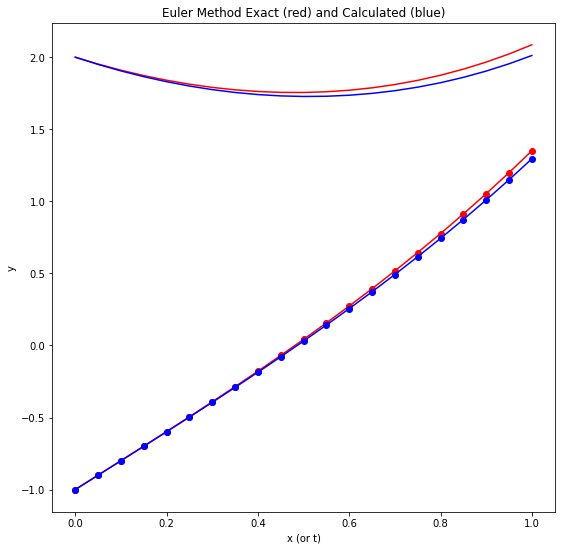

In [79]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys

#Make a bunch of lists to hold all our data. 
positionList = []
truthList0 = []
truthList1 = []
calculatedList0 = []
calculatedList1 = []
#This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
            calculatedList0.append(float(row[3]))
            calculatedList1.append(float(row[5]))
        else:
            truthList0.append(float(row[4]))
            truthList1.append(float(row[8]))
        i = i+1

#Next we plot it all using matplotlib. 
fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title(key + ' Method Exact (red) and Calculated (blue)')
ax.plot(positionList, truthList0, color='r')
ax.plot(positionList, calculatedList0, color='b')
ax.plot(positionList, truthList1, color='r', marker = 'o')
ax.plot(positionList, calculatedList1, color='b', marker = 'o')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'

[5](#5) NRPy+ "Solving the Scalar Wave Equation"

[6](#6) https://www.dataquest.io/blog/read-file-python/

[7](#7) https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib

[9](#9) https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine

The line with cirlces is u', while the one without is u itself. If the Euler method was used, as was set by default, we should see some clear divergence by the end of the procedure: the values start out nearly the same between calculated and exact but slowly diverge. Orders that are much higher than that will produce essentially no discernable difference between the two graphs, everything will look blue. Which is not to say the result is perfect, merely that the difference is not discernable at this scale.

Therefore we usually don't try to compare data to truth this way, we instead look at the errors directly. 

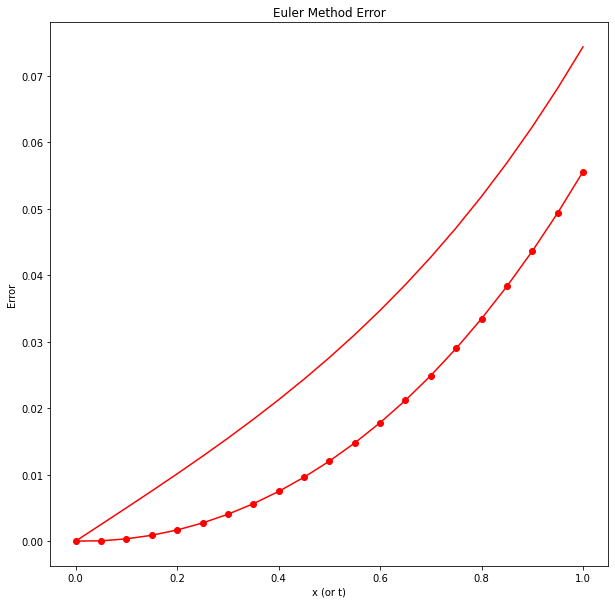

In [80]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys

#Make a bunch of lists to hold all our data. 
positionList = []
errorList0 = []
errorList1 = []
#This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
        else:
            errorList0.append(float(row[2]))
            errorList1.append(float(row[6]))
        i = i+1

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Error')
ax.set_title(key + ' Method Error')
ax.plot(positionList, errorList0, color='r')
ax.plot(positionList, errorList1, color='r', marker = 'o')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(10,10)

Admittedly, the above graph isn't particuarly illumiating in most cases, it genreally just shows that errors rise with time. The program reports error in an exact sense: it can be positive or negative and indicates precisely how far off from the truth the result was. Often, however, we care less about that and care more about the relative error, since that can be plotted on a logarithmic scale to tell us to how many significant figures our program matches the truth. 

In this case, we define relative error as:

$$ \left| \frac{Truth - Calculated}{Truth} \right| $$

The errorr reported by the program is just $Truth - Calculated$. But no worries, this is very simple to resolve, for numpy can take the arrays we made and do operations on them. Like so...

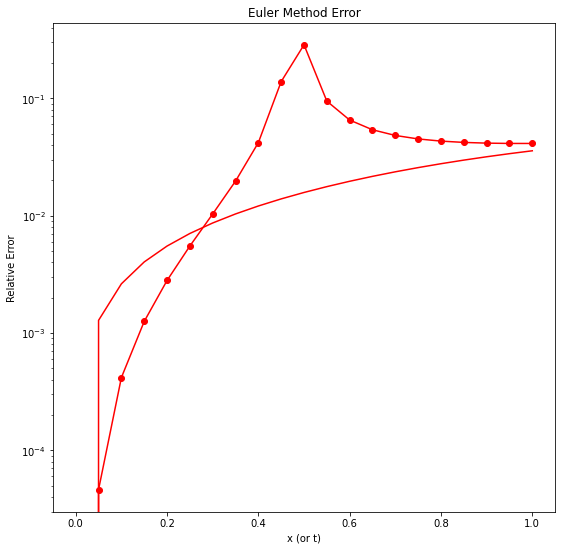

In [81]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
import numpy as np #numpy, for doing math with our data. 

#Make a bunch of lists to hold all our data. 
positionList = []
errorList0 = []
errorList1 = []
truthList0 = []
truthList1 = []
#This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
        else:
            errorList0.append(float(row[2]))
            errorList1.append(float(row[6]))
            truthList0.append(float(row[4]))
            truthList1.append(float(row[8]))
        i = i+1

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error')
ax.set_title(key + ' Method Error')
ax.plot(positionList, abs(np.array(errorList0)/np.array(truthList0)), color='r')
ax.plot(positionList, abs(np.array(errorList1)/np.array(truthList1)), color='r', marker = 'o')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.

This tells us a lot more than the simple error plot! First of all, assuming the parameters have not been adjusted by the user, we can see clearly that the error starts at around 1e-3 and grows to 1e-2. Naturally this is not very good, less than 2 sig figs of agreement at the end, but this is Euler's method, we know it's not very good, we specifically chose it so we could visually see features on the full scale. 

One thing we do note is that the errors for the function u are well behaved and don't do anything unusual, slowly growing as is to be expected. However, the errors for u' spike in the middle! Why is this? Well, if we look at how u' itself behaves in the first graph, that is where it crosses the x axis--that is, u'=0 at some point. As the values get closer to zero, they get smaller and smaller, and thus the relative error between said values increases markedly. We could not see this feature in the direct error plot, but here it's on full display! Being aware of points where functions go to zero is an important part of analyzing them properly, and spikes like this in the error can be used to find them. 

These are generally the three graphs we make from one run of the program. However, there is more informaiton we can glean from running it multiple times. 

<a id='S3f'></a>

## Step 3f: Multiple-Run Examination \[Back to [top](#toc)\]
$$\label{S3f}$$

#### Sometimes doing it once just won't cut it.

Further validation of the program can be done if it's run multiple times. Since trying to do that from scratch in this notebook would just fill it with C-declarations, we will use data from previous runs of the system to construct the following graphs. What follows are runs performed with the exact same program as above, but the method was RK4. We did the evaluation with two different step sizes: 0.01, and 0.02 with SIZE of 100 and 50, repsectively. When plotted together, the results are:

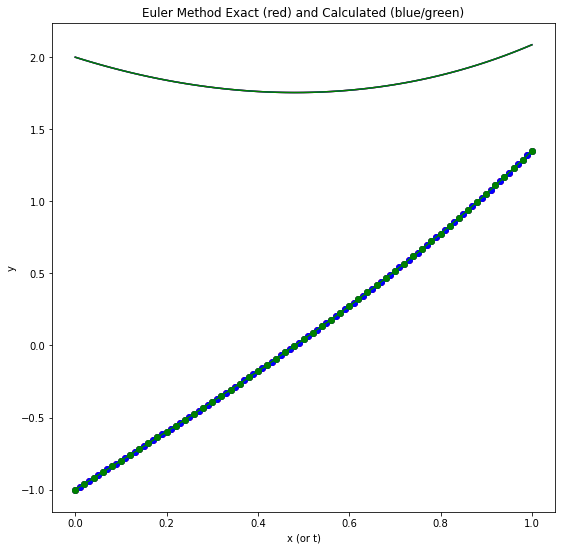

In [21]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys

#Make a bunch of lists to hold all our data. 
positionList = []
truthList0 = []
truthList1 = []
calculatedList0 = []
calculatedList1 = []

#"a" appended to the front of lists to be used for the second data set.
#truth list is irrelevant, the value is the same for both. 
apositionList = []
acalculatedList0 = []
acalculatedList1 = []
#This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/RKData01.txt') as f: #this file is stored in the folder, not produced at runtime.
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
            calculatedList0.append(float(row[3]))
            calculatedList1.append(float(row[5]))
        else:
            truthList0.append(float(row[4]))
            truthList1.append(float(row[8]))
        i = i+1
i = 0
with open(sys.path[0] + '/RKData02.txt') as f: #this file is stored in the folder, not produced at runtime.
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            apositionList.append(float(row[1]))
            acalculatedList0.append(float(row[3]))
            acalculatedList1.append(float(row[5]))
        i = i+1


#Next we plot it all using matplotlib. 
fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title(key + ' Method Exact (red) and Calculated (blue/green)')
ax.plot(positionList, truthList0, color='r')
ax.plot(positionList, calculatedList0, color='b')
ax.plot(apositionList, acalculatedList0, color='g')
ax.plot(positionList, truthList1, color='r', marker = 'o')
ax.plot(positionList, calculatedList1, color='b', marker = 'o')
ax.plot(apositionList, acalculatedList1, color='g', marker = 'o')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'

Naturally, viewing it from the bird's eye view reveales absolutely nothing, as the truth, 0.01 step, and 0.02 step results are all essentially right on top of each other. We can tell that the resolution is different only because the dots use to mark u' values are not in the same locations along the line. We have to examine the log plot to get anything useful out of this. 

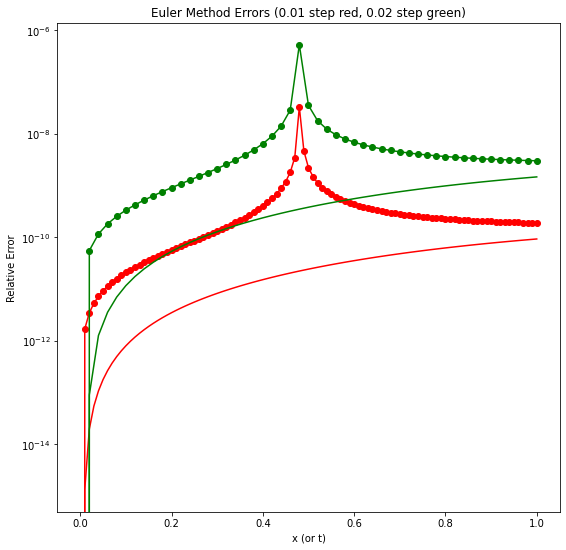

In [22]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys

#Make a bunch of lists to hold all our data. 
positionList = []
truthList0 = []
truthList1 = []
errorList0 = []
errorList1 = []

#"a" appended to the front of lists to be used for the second data set.
#truth list matters now as we need to be calculating relative errors.
apositionList = []
atruthList0 = []
atruthList1 = []
aerrorList0 = []
aerrorList1 = []
#This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/RKData01.txt') as f: #this file is stored in the folder, not produced at runtime.
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
        else:
            truthList0.append(float(row[4]))
            truthList1.append(float(row[8]))
            errorList0.append(float(row[2]))
            errorList1.append(float(row[6]))
        i = i+1
i = 0
with open(sys.path[0] + '/RKData02.txt') as f: #this file is stored in the folder, not produced at runtime.
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            apositionList.append(float(row[1]))
        else:
            atruthList0.append(float(row[4]))
            atruthList1.append(float(row[8]))
            aerrorList0.append(float(row[2]))
            aerrorList1.append(float(row[6]))
        i = i+1

#Next we plot it all using matplotlib. 
fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error')
ax.set_title(key + ' Method Errors (0.01 step red, 0.02 step green)')
ax.plot(positionList, abs(np.array(errorList0)/np.array(truthList0)), color='r')
ax.plot(positionList, abs(np.array(errorList1)/np.array(truthList1)), color='r', marker = 'o')
ax.plot(apositionList, abs(np.array(aerrorList0)/np.array(atruthList0)), color='g')
ax.plot(apositionList, abs(np.array(aerrorList1)/np.array(atruthList1)), color='g', marker = 'o')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'
ax.set_yscale("log") #found in matplotlib's documentation.

We note the very curious result that while the errors are different in magnitude, their shape is virtually identical. The fact that 0.02 has more error than 0.01 is expected: smaller step size leads to higher resolution. But it almost looks as though there is a relaiton between the two errors. That is because there is a relation, that relation is based on the order of the error itself. Adjusting the step size by a factor of two should introduce an error difference of ariybd $2^m$, where m is the order of the error. in this case, m is 4, so we should see error adjustments by a factor of 16. Do we? 

The best way to test is just to plot it again, but scale one of the values by 16.

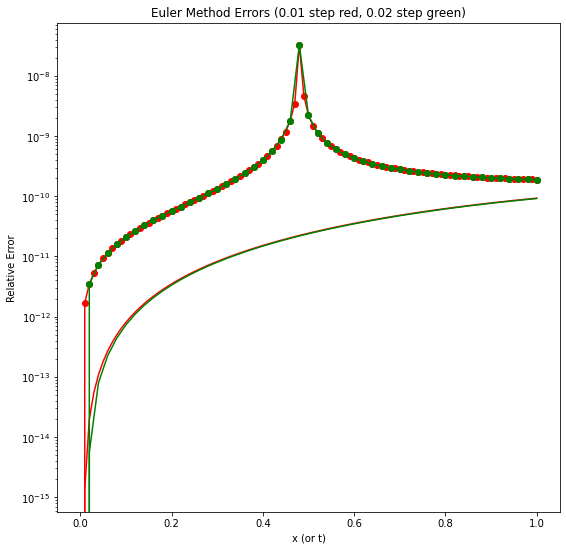

In [23]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys

#Make a bunch of lists to hold all our data. 
positionList = []
truthList0 = []
truthList1 = []
errorList0 = []
errorList1 = []

#"a" appended to the front of lists to be used for the second data set.
#truth list matters now as we need to be calculating relative errors.
apositionList = []
atruthList0 = []
atruthList1 = []
aerrorList0 = []
aerrorList1 = []
#This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/RKData01.txt') as f: #this file is stored in the folder, not produced at runtime.
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
        else:
            truthList0.append(float(row[4]))
            truthList1.append(float(row[8]))
            errorList0.append(float(row[2]))
            errorList1.append(float(row[6]))
        i = i+1
i = 0
with open(sys.path[0] + '/RKData02.txt') as f: #this file is stored in the folder, not produced at runtime.
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            apositionList.append(float(row[1]))
        else:
            atruthList0.append(float(row[4]))
            atruthList1.append(float(row[8]))
            aerrorList0.append(float(row[2]))
            aerrorList1.append(float(row[6]))
        i = i+1

#Next we plot it all using matplotlib. 
fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error')
ax.set_title(key + ' Method Errors (0.01 step red, 0.02 step green)')
ax.plot(positionList, abs(np.array(errorList0)/np.array(truthList0)), color='r')
ax.plot(positionList, abs(np.array(errorList1)/np.array(truthList1)), color='r', marker = 'o')
ax.plot(apositionList, abs(np.array(aerrorList0)/np.array(atruthList0)/16.0), color='g')
ax.plot(apositionList, abs(np.array(aerrorList1)/np.array(atruthList1)/16.0), color='g', marker = 'o')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'
ax.set_yscale("log") #found in matplotlib's documentation.

The scaling factor of 16 has made it so the two error plots are more or less right on top of each other. They agree remarkably, even near the spike as u' approaches zero. 

This is effectively a validation check for the RK4 method itself--is it consistent with its supposed fourth-order accuracy? As we can see here, yes, absolutely. Everything matches. With that, we consider the Simple Example complete. We can now move on to a more complciated example, one where the truth is not known. 

<a id='S4'></a>

## Step 4: Complicated Problem Example \[Back to [top](#toc)\]
$$\label{S4}$$

#### Don't hang up yet, I'm not done.

The program is more than capable of handling questions that are far more complicated than a simple second-order differential equation. For instance, in General Relativity there are a sequence of equations called the TOV equations, the primary isntance of which is described on wikipedia [here](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation). In genreal, the TOV equations represent a relativistic picture of a spherically symmetric star with respect to the radius. 

The specifics of why we wish to solve the TOV equations are unimportant, what is important is the form they take. There are many ways to state and evaluate them, but the one we will implement here is given by the following:

$$
\boxed{
\begin{matrix}
\frac{dP}{dr} &=& - \frac{1}{r} \left( \frac{\rho + P}{2} \right) \left(\frac{2 m}{r} + 8 \pi r^2 P\right) \left(1 - \frac{2 m}{r}\right)^{-1} \\
\frac{d \nu}{d r} &=& \frac{1}{r}\left(1 - \frac{2 m}{r}\right)^{-1} \left(\frac{2 m}{r} + 8 \pi r^2 P\right) \\
\frac{m(r)}{dr} &=& 4\pi r^2 \rho(r) \\
\frac{d\bar{r}(r)}{dr} &=& \left(1 - \frac{2m}{r} \right)^{-1/2} \frac{\bar{r}(r)}{r}
\end{matrix}
}\
$$

Taken from the soon-to-be-depricated [NRPy+ TOV solver](http://localhost:8889/notebooks/Tutorial-ADM_Initial_Data-TOV.ipynb). P is pressure, $\nu$ doesn't correlate to something easily seen as physica, m is the total enclosed mass of the star, and r-bar is the isotropic radius (non-normalized). Though, really, as an example the physical meaning of the results are unimportant. 

In various implementations and models, the function $\rho$ (energy density) can vary. In our implementation here, we treat it as

$$ \rho(r) = \sqrt{P} + P $$

Which we will report as a separate constant, making use of our program's functionality in this regard. For the record, a fuller definition of $\rho(r)$ would be...

$$ \rho(r) = (P/K)^{1/\Gamma} (1 + \frac{P}{(P/K)^{1/\Gamma} (\Gamma - 1)})$$

However, in our implementation K=1 and $\Gamma = 2$ so it quickly reduces to our original declaration. 

Another thing we need is initial conditions. The pressure has to be specified ahead of time, but all other values start at zero. In our case, Pressure is 0.016714611225000002. 

With all this, we have 4 differential equations and 1 constant we wish to report. We also need to consider our boundary conditions. Traditionally, we start from the center of the star at r=0. This, naturally, will provide some issues as the solver will run into divide by zero errors if it tries to evaluate any point there. However, in our declaration we will demonstrate how to avoid this issue, as well as avoiding problems that will arise if, say, the pressure goes negative due to an estimation error and makes the energy density NaN, which breaks everything. It can all be handled in the program so long as it is implemented properly. 

Note that unlike the Simple Problem, we do not know what the answer should be ahead of time, so there will be no relative error reporting this time around--but we will still have other forms of analysis. 

<a id='S4a'></a>

## Step 4a: Complicated Problem Customization  \[Back to [top](#toc)\]
$$\label{S4a}$$

#### Curiously not more complicated than the simple version of this section. 

Here is where users can adjust information in the notebook to adjust how the program runs. These changes only apply to the Complicated Example, the Simple Example and the final fully customizable code have their own customization sections. 

In [112]:
#This is the method variable, used to choose how the program calculates the result. 
key = "RK4"
#Possible options: "Euler" (Order 1), "RK2 Heun" (Order 2), "RK2 MP" (2), 
#"RK2 Ralston" (2), "RK3" (3), "RK3 Heun" (3), "RK3 Ralston" (3), "SSPRK3" (3),
#"RK4" (4), "DP5" (5), "DP5alt" (5), "CK5" (5), "DP6" (6), "L6" (6), "DP8" (8) 

#This is the step size. 
step = "0.01"
#Can be any number, 0.01 by default. Note that this is a string--we are passing it to
#the C code generator as a string. Be very careful not to declare it as something that isn't
#a number. 

#This is the number of steps.
size = "100"
#Can be any integer, 1000 by default. Be sure to make it actually be an integer. 
#Note that this time we have a termination condition, so we will not hit all 100 steps. 

#Unless you're adding another function or wish to report a constant, do not change the two settings below. 
#this is the number of equations in the system of differential equations
eNum = "4"
#make sure this is an integer.

#this is the number of constants we wish to report.
cNum = "1"
#make sure this is an integer.

#more coming eventually: functions and boundary values.
#though those two might be a while. 

<a id='S4b'></a>

## Step 4b: Complicated Problem Python-Code \[Back to [top](#toc)\]
$$\label{S4b}$$

#### The snakes complain that there's nothing different to do here. 

As with the simple example, we have to grab the Butcher Table and format it properly. The code here is absolutely identical to the previous example, it is simply replicated here for clarity. 

In [113]:
import sympy as sp              # SymPy: The Python computer algebra package upon which NRPy+ depends
import numpy as np              # NumPy: A numerical methods module for Python
from RK_Butcher_Table_Dictionary import Butcher_dict #the Butcher Tables themselves. 

#The end result of all this should be a string with our chosen method. 
#If you want to set the method, see above. 

butcherTable = ""

#Now in order to determine what size to make our loop, we need the size of the table itself.
print(len(Butcher_dict[key][0]))
rows = len(Butcher_dict[key][0])
i = 0

#Set up th edeclaration of the double 2D array in C. 
butcherTable = butcherTable + "double butcher[" + str(len(Butcher_dict[key][0])) + "][" + str(len(Butcher_dict[key][0])) +"] = {"

while (i < rows):
    print(len(Butcher_dict[key][0][i]))
    #The above print function helps us see that the program really is doing the entire matrix.
    columns = len(Butcher_dict[key][0][i])
    butcherTable = butcherTable + "{"
    #Even though the matrix is square, we cannot set rows=columns since 
    #The butcher tables have a lot of empty slots we will be filling with 0s. 
    j = 0
    if Butcher_dict[key][0][i][j] == '':
        butcherTable = butcherTable + str(float(Butcher_dict[key][1]))+ ","
        j = j+1
        # This is a check for the empty spot in the bottom left of the table
        # the C-code uses this to store the method order, so we put it there. 
        # The main bennefit is that this keeps the matrix square.
    while (j < rows): #not < columns, since we still need to fill in 0s for 
        #the C code. 
        if (j < columns):
            butcherTable = butcherTable + str(float(Butcher_dict[key][0][i][j]))
            # Print the number requested. 
            # Note the conversion to floating point. The C-code has no clue what to
            # do with fractions, so they must be changed. 
            if (j<rows-1):
                butcherTable = butcherTable + ","
                #if not at end of row, add comma. WE don't want to overdo it. 
        elif (j < rows-1):
            butcherTable = butcherTable + "0"+ ","
            # if we are at the point where there are no numbers, fill with 0. 
        else:
            butcherTable = butcherTable + "0"
            # if we are at the point where there are no numbers, fill with 0. 
            # end of row does not have the comma addition. 
        j = j+1
    if(i < rows-1):
        butcherTable = butcherTable + "},"
    else:
        butcherTable = butcherTable + "}"
    # After every row, we need a brace, but the added comma is not needed on the last one.
    i = i+1
butcherTable = butcherTable + "};"
print(butcherTable)



5
1
2
3
4
5
double butcher[5][5] = {{0.0,0,0,0,0},{0.5,0.5,0,0,0},{0.5,0.0,0.5,0,0},{1.0,0.0,0.0,1.0,0},{4.0,0.16666666666666666,0.3333333333333333,0.3333333333333333,0.16666666666666666}};


With that, now we can start setting up the file within which we will run the C code. Once again, we rely on NRPy+'s abilities to do this. 

In [114]:
import outputC as outC       #NRPy+: Core C code output module.
import cmdline_helper as cmd #NRPy+: Multi-platform Python command-line interface
import os                    #Python: Miscellaneous operating system interfaces
import shutil                #Python: High level file operations

# https://github.com/zachetienne/nrpytutorial/blob/master/Tutorial-Start_to_Finish-Finite_Difference_Playground.ipynb

#Create a C code output directory
#First, name it.
Ccodesrootdir = os.path.join("ODESolver_Complicated_Ccodes/")
#Remove any previously existing files there.
shutil.rmtree(Ccodesrootdir,ignore_errors=True)
#Create the fresh directory. 
cmd.mkdir(Ccodesrootdir)

<a id='S4c'></a>

## Step 4c: Complicated Problem C-Code \[Back to [top](#toc)\]
$$\label{S4c}$$

#### Time to make use of some real power.

Below is the C-Code. Numerous output lines are commented out and can be un-commented at will if a user wishes to examine in more detail what's happening during runtime. (Though in this notebook that is likely not necessary as the terminal output is just placed in a text file.) Code is heavily commented, some of it is likely redundant with the section above, but looking at things two different ways rarely hurts. 

The C-code generated here can also be found in pure C form, though it only has one of each of the first five orders of solution methods as possibilities, as it is unable to interface with NRPy+ directly. 

If a user wishes to examine the code in detail, we highly recommend opening the .c version in a coding editor with C in mind, since jupyter notebook is going to color all the C-Code red because we pass it through Python as a very large string. 

Yes, it is a very large block of text that is hard to read. We recommend looking for python comments marked with # to understand what exactly is being done. Unlike the Simple Example, here we will be using a lot of the extra functionality of the solver, but will not be reporting errors since this is a situation where we don't know what the truth is. 

In [115]:
#Now define our c function itself. To do that, we need to build the strings that actually make up the C-function. 
#when creating functions, NRPy+ takes several arguments, each one with its own important role:
#includes: this is where all the .h files that the C program relies on are declared, in the form of a list. 
#prefunc: any functions that exist outside of main() are declared here. For the purposes of this tutorial, we 
#explicitly declare these functions one at a time and go over them, but more often all of them are passed
#to prefunc as a long string all at once. 
#desc: contains a description of the method.
#c_type: what type does the main() function return? This is usually int. 
#name: what is the name of the main() function? Usually just main. 
#params: a place to put special parameters. Usually blank.
#body: the actual body of the main function and the majority of text density on any given document. 

#The most important part to go over is prefunc, for it is the part the user is expected to interact with.
#We consider its construction here step-by-step, one function at a time. 
#we use the format r""" """ to pass string literals so the C-code slashes don't mess up Python's compiler. 

aString = r"""
void diffyQEval (double x, double y[], double c[])
{
    //Efficient(ish) Assignment Method
    //This computes the values of the *derivatives* of the functions, so what we are passed
    //in the array y[] is *not* the same thing as what we are calculating, be careful not to re-use
    //outside of the function, because we are taking in the function itself and replacing it with its derivative. 
    //This is somewhat counter-intuitive, but it is efficient. 

    //This if statement is an example of a special condition, in this case at x=0 we have a divide by zero problem. 
    //In this case we manually know what the derivatives should be.
    //Alternatively, we could define piecewise equations this way. 
    if(x == 0) {
        y[0] = 0; 
        y[1] = 0;
        y[2] = 0;
        y[3] = 1;
    }
    else {
        double y0 = y[0]; //Pressure
        double y1 = y[1]; //nu. Uncertain what this physically is, likely just a bookkeeping situation. 
        double y2 = y[2]; //Total mass. 
        double y3 = y[3]; //r-bar, the isotropic radius. NOT NORMALIZED. Must be normalized in post-processing. 

        //Note that we declare these buffer variables since we will need to use them multiple times, but we are also
        //overwriting them in the original array, so we need buffers. 
        y[0] = -((c[0]+y0)*( (2.0*y2)/(x) + 8.0*M_PI*x*x*y0 ))/(x*2.0*(1.0 - (2.0*y2)/(x)));
        y[1] =  ((2.0*y2)/(x) + 8.0*M_PI*x*x*y0)/(x*(1.0 - (2.0*y2)/(x)));
        y[2] = 4*M_PI*x*x*c[0];
        y[3] = (y3)/(x*sqrt(1.0-(2.0*y2)/x));
    }
    //This funciton is not guaranteed to work in all cases. For instance, we have manually 
    //made an exception for x=0, since evaluating at 0 produces infinities and NaNs. 
    //Be sure to declare any exceptions before running, both here and in exceptionHandler(), depending 
    //on the kind of exception desired.  
}

"""

#The above function is where a user would declare the actual set of differential equations to be solved. 
#Here we have declared the TOV equations, all four of them. 
#Note that we have an if statement here. This is an example of careful declaration.

#The if statement catches when we're trying to evaluate a function at zero, which would go very badly
#aince most of the equations contain 1/r, which is going to break everything. Thus, when we evaluate
#at r=0 (or x=0 in the code), we replace the values with known ones. 
#The determination of these values was analytic in nature: pressure, nu, and mass all have to have
#a derivative of zero at r=0 since they are smooth functions and the star is spherically symmetric. 
#The isotropic radius is a little different, we assume here that it has a derivative of 1, that is, 
#it scales directly with the radius r itself at the start. This is just an assumption to get it to
#calculate. The produced result will be incorrect, but it will be *relatively* correct. The actual
#isotropic radius will be found by normalizing the data produced by this. We are allowed to do this since
#none of the other functions in the system depend on the isotropic radius. 

#Such an if statement could also be used to declare piecewise differential equations. 

#Note the nuance: we are being passed an array with values y, but we change it to contain values y', the derivatives.
#This is why we make sure to declare double variables when doing this, in case, say, the derivative of y1 depends
#On y0. These coupled reliances exist here, too; if we changed y2 and then tried to evaluate the y3', we would be incorrect. 
#Users can also declare piecewise functions here with a C if statement, should it be desired. 

aString = aString + r"""
void getInitialCondition (double y[])
{
    //be sure to have these MATCH the equations in diffyQEval
    y[0] = 0.016714611225000002; //Pressure
    y[1] = 0.0; //nu
    y[2] = 0.0; //mass
    y[3] = 0.0; //r-bar
}
"""

#We have added another function, the getInitialCondition function, which is used to stare initial conditions. 
#These are the initial conditions of the actual functions, not their derivatives. 
#When declaring new initial conditions, make sure they match the order of the differential equations in DiffyQEval()!
#The program assumes the values you insert here are correct, this will lead to problems if they are not. 
#The initial condition for the Pressure comes from the "central baryon density," via P = Krho_b^Gamma = rho_b^2. 
#The baryon density here was chosen to be 0.129285, taken from NRPy+'s TOV solver

aString = aString + r"""
void constEval (double y[], double c[])
{
    //Sometimes we want to evaluate constants in the equation that change, but do not have derivative forms.
    //Today, we do that for the total energy density. 
    double c0 = c[0];
    //Make sure to instantiate buffer values so you don't end up changing things when you don't want to!
    //Not necessary here, but left in as a demonstration. 
    c[0] = sqrt(y[0]) + y[0];
    //The total energy density only depends on pressure. 
}

"""

#Today we have a constant to evaluate, the total energy density. It depends entirely on y[0] (Pressure), however
#the program supports constants that depend on any number of the actual differential equation values. 

aString = aString + r"""
void knownQEval (double x, double y[])
{
    //This function is only used if there are known solutions. 
    //Notably this is not the case for the TOV equations. 
    //If you do put anything here, make SURE it has the same order as the differential equations. 
    //In the case of TOV, that would be Pressure, nu, mass, and r-bar, in that order. 
}

"""

#We do NOT know the solution to the TOV equations, so we leave this function empty save for some comments. 
#If we did have an exact result, it would need to be declared in the same order as the differential equations.

aString = aString + r"""
void exceptionHandler (double x, double y[], double c[])
{
    //This funciton might be empty. It's only used if the user wants to hard code some limitations 
    //On some varaibles.
    //Good for avoding some divide by zero errors, or going negative in a square root. 
    if (y[0] < 0) {
        y[0] = 0;
    }
    //In this case, the TOV Equations, we need to make sure the pressure doesn't go negative.
    //Physically, it cannot, but approximation methods can cross the P=0 line
    //We just need a hard wall to prevent that. 
}

"""

#This time, we do need an exception handler. In this case, we knot that the total energy density (rho)
#is determined by taking the square root of the pressure. If RK methods were perfect, there would
#be no problem here, since the only way this would be undefined is if Pressure went negative. Physically,
#this is impossible. However, RK methods are not perfect and when evaluating values near 0, they can
#easily throw out small values just below zero. This will break everything when the program tries
#to take a square root. So, if we ever detect that pressure has dropped below zero, we set it *to* zero
#to prevent this from occuring. 

#If a user is getting a lot of NaN and inf results, chances are the program is trying to evaluate something
#like a negative square root. The exception handler can also be used to force boundaries on the way the data
#evolves, such as modeling a "wall" by preventing a value from increasing beyond a certain point. 

aString = aString + r"""
int doWeTerminate (double x, double y[], double c[])
{
    //This funciton might be empty. It's only used if the user wants to have a special termination condition.
    //Today we do. We terminate once the pressure hits zero, or goes below it. 
    if (y[0] <= 0.0) {
        return 1;
    } else {
        return 0;
    }
    //return 1 for termination.
}

"""

#We also have a termination condition. Once the pressure drops to zero, we know we have reached the
#edge of the star and don't particuarly care what exists outside of it. 

def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h", "time.h"]
    # what "#include" lines do we include at the top?
    
    prefunc = aString
    #prefunctions are functions declared outside main.
    #the specifics of what go here were declared above. 
    
    desc = "Complicated Example: TOV Solver With Basic Assumptions."
    #just put a guide as to what the code actually does here. 
    
    c_type = "int" 
    #what does main return?
    
    name = "main"
    #will almost always just be "main", but could be otherwise. 
    
    params = ""
    #various paremeters. Should be "" most often. 
    
    #Below is where the actual main function itself goes, constructed from the variables
    #defined in the customization section.
    #Anything that isn't red indicates where we are inserting something, such as the butcherTable or step size. 
    body = butcherTable + r"""
    printf("Beginning ODE Solver \"Odie\" V7...\n");
    
    //SECTION I: Preliminaries
    //Before the program actually starts, variables need to be created
    //and set, as well as the functions chosen. 
    //The system of differential equations can be found declared in diffyQEval().

    double step = """ + step + r"""; //the "step" value.
    double bound = 0.0; //where the boundary/initial condition is. Same for every equation in the system.
    int numberOfEquations = """ + eNum + r"""; //How many equations are in our system?
    int numberOfConstants = """ + cNum + r"""; //How many constants do we wish to separately evaluate and report? 
    //If altering the two "numberOf" ints, be careful it doesn't go over the actual number and cause an overflow 
    //in the functions above main()
    const int SIZE = """ + size + r"""; //How many steps we are going to take?
    bool validate = false; //Set to true if you wish to run a validation test. Only works if solution is already known.
    //Spits out nonsense if no solution is provided.
    //BE WARNED: setting validate to true makes it print out all error data on a second line, the file will have
    //to be read differently.

        //How to get array size: https://stackoverflow.com/questions/37538/how-do-i-determine-the-size-of-my-array-in-c
    size_t methodSize = sizeof(butcher)/sizeof(butcher[0][0]);
    int dimension = sqrt((int)methodSize);
    //We need to know how big our method is, especially if passed one we've never seen before. 
    if (validate == true) {
        printf("Method Order: %i. \nOrder of Error should be near to or larger than Method Order + 1.\n",(int)butcher[dimension-1][0]);
        printf("If not, try a larger step size, roundoff error may be interfering.\n");
    } else {
        printf("Method Order: %i.\n",(int)butcher[dimension-1][0]);
    }
    //If validation is not needed, we don't care about the Order of the Error. 

    double y[numberOfEquations];
    double c[numberOfConstants];
    //These variables temporarily store the values calculated before they are 
    //printed to the output file and forgotten.
    //y is the values of the actual equations. 
    //c is just used to hold any constants we wish to report. 
    //Each array only holds values at one evaluation point, but one for each Equation.

    //This here sets the initial conditions as declared in getInitialCondition()
    getInitialCondition(y); 

    //This evaluates any constants that might be needed for evaluating the actual differnetial equations. 
    constEval(y,c);

    //SECTION II: The Loop

    //prior to beginning the loop, start the timer. 
    double startN = time(NULL);
    //printf("Time: %.90f seconds\n", startN);
    //set start time to current time.  Uncomment to print.

    //also open the file we'll be writing data to. 
    FILE *fp;
    fp = fopen("oData.txt","w");

    //First though, let's print out our initial data. The print function needs to be adaptable to any size of data. 
    //We can do this with multiple print functions and just not adding the newline character until we're done.
    //We print both to console and to the file for the initial conditions, but later only print to file.
    //First, print the location we are at. 
    printf("INITIAL: Position:,\t%f,\t",bound);
    fprintf(fp, "Position:,\t%f,\t",bound);
    //Second, go through and print the result for every single equation in our system.
    for (int n = 0; n < numberOfEquations; n++) {
        printf("Equation %i:,\t%10.9e,\t",n, y[n]);
        fprintf(fp, "Equation %i:,\t%10.9e,\t",n, y[n]);
    }
    //Third, print out desired constants.     
    for (int n = 0; n < numberOfConstants; n++) {
        printf("Constant %i:,\t%10.9e,\t",n, c[n]);
        fprintf(fp, "Constant %i:,\t%10.9e,\t",n, c[n]);
    }
    //Lastly, the newline character. 
    printf("\n");
    fprintf(fp,"\n");
    //Comma delimiters are printed to the file so it can be converted to .csv with ease. 

    if (validate == true) {
        //In order to keep things neat and regular in the file, print a first line of errors. 
        //Even though by necessity all of them must be zero. 
        fprintf(fp, "Errors:,\t");
            for (int n = 0; n < numberOfEquations; n++) {
                fprintf(fp, "Equation %i:,\t0.0,\t",n);
                fprintf(fp, "Truth:,\t%10.9e,\t",y[n]);
            }
            for (int n = 0; n < numberOfConstants; n++) {
                fprintf(fp, "Constant %i:,\t0.0,\t",n);
                fprintf(fp, "Truth:,\t%10.9e,\t",c[n]);
            }   
            //printf("\n");
            fprintf(fp,"\n");
    }
    
    //This loop fills out all the data.
    //It takes a provided butcher table and executes the method stored within. Any table should work. 

    for (int i = 0; i < SIZE; i++){ 
        //i represents how many steps have been taken. 0 is the initial condition, that is, the variable `bound`. 
        double K[dimension][numberOfEquations];
        //These are the K-values that are required to evaluate RK-like methods. 
        //They will be determined based on the provided butcher table.
        //This is a 2D matrix since each diffyQ has its own set of K-values. 

        //Since we'll be calling K while it's empty, even though there should be no errors due
        //to the way it's set up, let's go ahead and fill it with zeroes.
        for (int j = 0; j<dimension; j++) {
            for (int n = 0; n<numberOfEquations; n++) {
                K[j][n]=0.0;
            }
        } 

        double yInsert[numberOfEquations];
        //We also need an array for the inserted y-values for each equation. 
        //Most applications actually have the different yInsert values be independent, so 
        //if we knew the form of the equation we could simplify the code.
        //However, we need to make sure to always fill everything in case we have a system
        //of the form y'=f(u,y) u'=g(u,y)

        double cInsert[numberOfConstants];
        //Create an array to hold the constants we want.
        //Surprisingly, does not throw an error when the number is zero. Neat.

        for (int j = 1; j < dimension; j++) {
            //Due to the way the Butcher Table is formatted, start our index at 1 and stop at the end. 
            double xInsert = bound+i*step + butcher[j-1][0]*step;
            //x does not change much for different tables, just adjust the "step correction" term.
            //x is the same for every equation too.

            for (int n = 0; n < numberOfEquations; n++) {
                yInsert[n] = y[n];
            } 
            //This is set since y is our actual value, but we will be adjusting yInsert a lot to find the next y. 

            for (int n = 1; n < dimension; n++) {
                //Once again, start at index of 1 rather than 0.
                for (int q = 0; q < numberOfEquations; q++) {
                    yInsert[q] = yInsert[q] + butcher[j-1][n]*K[n][q];
                }
                //Each individual yInsert portion is dependent on one of the K values.
                //K values are initially set to zero even though technically whenever 
                //we would use an undeclared K-value the butcher table would have zero.
                //You know, just in case something goes wrong. 
            }
            
            //Check for any limitations on our results. 
            exceptionHandler(xInsert,yInsert,cInsert);

            //Evaluate the constants. 
            constEval(yInsert,cInsert);

            //Now we actually evaluate the differential equations. 
            diffyQEval(xInsert, yInsert, cInsert);
            //yInsert comes out as evaluated derivatives, and is now in a form we can use. 

            for (int n = 0; n < numberOfEquations; n++) {
                K[j][n] = step*yInsert[n];
                //Fill in the K-values. 
            } 
        }

        //Now that we have all the K-values set, we need to find the actual result in one final loop.
        for (int n = 0; n< numberOfEquations; n++) {
            K[0][n] = y[n]; //The 0th spot in the K-values is reserved for holding the 
            //final value while it's being calculated. 
            for (int j = 1; j < dimension; j++) {
                K[0][n] = K[0][n] + butcher[dimension-1][j]*K[j][n]; 
                //This is where the actual approximation is finally performed. 
            }
            if (validate == true) {
                yInsert[n] = y[n];
                //Before we change our initial ys, we save their data for the validation check now that
                //yInsert is not being used. 
            }
            y[n] = K[0][n]; //Set y to the new estimated value. 
        }

        //After each step is calculated, print results. 
        //However, prior to printing we need to run our exception and constant evaluators one more time. 
        exceptionHandler(bound+i*step,y,c);
        constEval(y,c);
        //Since we've usually been running them on yInsert, the actual y and c values have not generally seen 
        //the restrictions applied here. 

        //Uncomment for live updates.
        //printf(fp, "Position:,\t%f,\t",bound+(i+1)*step);
        fprintf(fp, "Position:,\t%f,\t",bound+(i+1)*step);
        for (int n = 0; n < numberOfEquations; n++) {
            //printf("Equation %i:,\t%10.9e,\t",n, y1[n]);
            fprintf(fp, "Equation %i:,\t%10.9e,\t",n, y[n]);
        }
        for (int n = 0; n < numberOfConstants; n++) {
            //printf("Constant %i:,\t%10.9e,\t",n, c[n]);
            fprintf(fp, "Constant %i:,\t%10.9e,\t",n, c[n]);
        }   
        //printf("\n");
        fprintf(fp,"\n");
                
        //validation: grab the first error for every equation, estimate its order, and continually report errors
        if (validate==true) {
            //We should only be here if we have a truth to compare against. 
            double saveErr1[numberOfEquations];
            double yTruth[numberOfEquations];
            double constErr1[numberOfConstants];
            double cTruth[numberOfConstants];
            //we need errors for both the differential equations and the constants. 
            //We only need one error array for reporting errors, but we will need a second for order checking. 
            exceptionHandler(bound+step*(i+1),yTruth,cTruth);
            knownQEval(bound+step*(i+1),yTruth);
            constEval(yTruth,cTruth);
            //Evaluate what yTruth is at our current point.
            //remember, i+1, not i, since we've already updated the previous point. 

            for (int n = 0; n < numberOfEquations; n++) {
                saveErr1[n] = (yTruth[n] - y[n]);
                //This calculates the errors we have right now. 
            } 
            for (int n = 0; n < numberOfConstants; n++) {
                constErr1[n] = (cTruth[n] - c[n]);
                //This calculates the constant errors we have right now. 
            } 

            if(i == 0.0) { 
                //The following is an algorithm for determining the rate of error 
                //convergence. A bit rudimentary, could be condensed, but is also only
                //called once so not relaly a concern and it is easier to read this way. 
                //Note that this only reports the estimated order for the differential equations, not constants. 
                double saveErr2[numberOfEquations];
                //Need to store a second error. 
                double step2 = step*0.5;
                //It is easier to just use another variable than multiply the step by 0.5 every time. 
                //Below not really commented since it is just a copy of what's above with minor tweaks.
                    for (int j = 0; j<dimension; j++) {
                        for (int n = 0; n<numberOfEquations; n++) {
                            K[j][n]=0.0;
                        }
                    }

                    double yInsertBuffer[numberOfEquations];

                    for (int j = 1; j < dimension; j++) {
                        double xInsert = bound+i*step2 + butcher[j-1][0]*step2;
                        
                        for (int n = 0; n < numberOfEquations; n++) {
                            yInsertBuffer[n] = yInsert[n];
                        } 
                        for (int n = 1; n < dimension; n++) {
                            for (int q = 0; q < numberOfEquations; q++) {
                                yInsertBuffer[q] = yInsertBuffer[q] + butcher[j-1][n]*K[n][q];
                            }
                        }

                        exceptionHandler(xInsert,yInsertBuffer,cInsert);

                        constEval(yInsertBuffer,cInsert);

                        diffyQEval(xInsert, yInsertBuffer, cInsert);
                        for (int n = 0; n < numberOfEquations; n++) {
                            K[j][n] = step2*yInsertBuffer[n];
                        }

                    }
                    for (int n = 0; n< numberOfEquations; n++) {
                        K[0][n] = yInsert[n];
                        for (int j = 1; j < dimension; j++) {
                            K[0][n] = K[0][n] + butcher[dimension-1][j]*K[j][n];
                        }
                    }
                //Now that we've performed the approximation's first step at half the size, we can estimate the order.
                //Create an array to hold the true values. 
                double truthValidate[numberOfEquations];
                //Fill it with the true values. 
                knownQEval(bound+step2,truthValidate);
                //Then print out the estimated order, one individually for each equation.
                for (int n = 0; n < numberOfEquations; n++) {
                    saveErr2[n] = (truthValidate[n] - K[0][n]);
                    printf("Order of Error: %i\t%f\n",n, log2(saveErr1[n]/saveErr2[n]));
                }
                //Note: this will not produce an integer, but with proper data it will be close to an integer
                //and the validation would be performed by rounding. 
                //Results can be larger than the order of the method+1, but should not be much smaller
                //However one can also get errors if the results are too exact, roundoff error can ruin the calcluation. 
                //Using larger step sizes usually removes that. 
            }
        
            //When validating, we add an extra line to the output file for errors.
            //prints the errors alongside the truth values. 
            fprintf(fp, "Errors:,\t");
            for (int n = 0; n < numberOfEquations; n++) {
                fprintf(fp, "Equation %i:,\t%10.9e,\t",n, saveErr1[n]);
                fprintf(fp, "Truth:,\t%10.9e,\t",yTruth[n]);
            }
            for (int n = 0; n < numberOfConstants; n++) {
                fprintf(fp, "Constant %i:,\t%10.9e,\t",n, constErr1[n]);
                fprintf(fp, "Truth:,\t%10.9e,\t",cTruth[n]);
            }   
            //printf("\n");
            fprintf(fp,"\n");

            //Note that error printed is not relative error, but simple difference error. 
        }

        //And the very last thing we do in the loop is ask if we terminate it. 
        if (doWeTerminate(bound+i*step, y, c) == 1) {
            i = SIZE;
        }
    }

    //SECTION III: Analysis
    //Minor post-processing goes here. 
    //Anything advanced will need to be done in the jupyter notebook that encloses this. 

    // basic reference: https://www.tutorialspoint.com/cprogramming/c_file_io.htm
    // used to be a file converter here, now there isn't, we just close the file. 
    fclose(fp);

    //TIMER
    double endN = time(NULL);
    //loop is complete, how long did it take?
    printf("Time Elapsed: %f seconds\n", endN-startN);
    //Only calculates to the closest second, for some reason.

    printf("ODE Solver \"Odie\" V7 Shutting Down...\n");
    return 0;

// - GM, master of dogs.
    """
    #Now everything is ready to be constructed. 
    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)
    #Now all those things we defined above are put into a function from outC, 
    #Which generates the actual entry in the C function dictionary. 
    
add_to_Cfunction_dict_ODESolver()
# Call the function we just declared above. 

cmd.new_C_compile(Ccodesrootdir, "ODESolver", compiler_opt_option="fast")
#This just compiles the code into the file ODESolver. 

os.chdir(Ccodesrootdir)
#Change the file path to the folder we created earlier. 

cmd.Execute("ODESolver", "", "terminalOutput.txt")
#Evaluate the C-code and put the Terminal output into a text file. 

OUCH! Found main in outC_function_master_list.
(EXEC): Executing `make -j10`...
(BENCH): Finished executing in 0.20 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3 ./ODESolver `...
(BENCH): Finished executing in 0.20 seconds.


<a id='S4d'></a>

## Step 4d: Complicated Problem Results \[Back to [top](#toc)\]
$$\label{S4d}$$

#### If it isn't the consequences of my own actions. ...Again. 

First, let's see what the terminal printed. 

In [116]:
with open("terminalOutput.txt") as f:
    print(f.read())

Beginning ODE Solver "Odie" V7...
Method Order: 4.
INITIAL: Position:,	0.000000,	Equation 0:,	1.671461123e-02,	Equation 1:,	0.000000000e+00,	Equation 2:,	0.000000000e+00,	Equation 3:,	0.000000000e+00,	Constant 0:,	1.459996112e-01,	
Time Elapsed: 0.000000 seconds
ODE Solver "Odie" V7 Shutting Down...



Note that the method of error isn't even stated here, we did not ask for a validation check since we don't know the answer. Do note that we now report the constant as well! 

The actual data produced by the program is below. Note: if the user chose a large SIZE it will be a very long result. Though we have it set to 100 by default so it's going to be large anyway. 

In [117]:
with open("oData.txt") as f:
    print(f.read())

Position:,	0.000000,	Equation 0:,	1.671461123e-02,	Equation 1:,	0.000000000e+00,	Equation 2:,	0.000000000e+00,	Equation 3:,	0.000000000e+00,	Constant 0:,	1.459996112e-01,	
Position:,	0.010000,	Equation 0:,	1.670668424e-02,	Equation 1:,	9.744995280e-05,	Equation 2:,	6.113877577e-07,	Equation 3:,	1.000030580e-02,	Constant 0:,	1.459610236e-01,	
Position:,	0.020000,	Equation 0:,	1.668656909e-02,	Equation 1:,	3.448581465e-04,	Equation 2:,	4.889513159e-06,	Equation 3:,	2.000242916e-02,	Constant 0:,	1.458630727e-01,	
Position:,	0.030000,	Equation 0:,	1.665320046e-02,	Equation 1:,	7.556732743e-04,	Equation 2:,	1.649133607e-05,	Equation 3:,	3.000822174e-02,	Constant 0:,	1.457004804e-01,	
Position:,	0.040000,	Equation 0:,	1.660659442e-02,	Equation 1:,	1.330289454e-03,	Equation 2:,	3.905422081e-05,	Equation 3:,	4.001951786e-02,	Constant 0:,	1.454731705e-01,	
Position:,	0.050000,	Equation 0:,	1.654683220e-02,	Equation 1:,	2.068533851e-03,	Equation 2:,	7.618621463e-05,	Equation 3:,	5.003815053e-02,

Note that there are no errors reported, just the positions, values of our functions, and the value of our constant. This should be the full solution to the system of differential equations. 

<a id='S4e'></a>

## Step 4e: Complicated Problem Analysis \[Back to [top](#toc)\]
$$\label{S4e}$$

#### Time to go mining again. 

Let's just print out our equations and constant, see how they behave. 

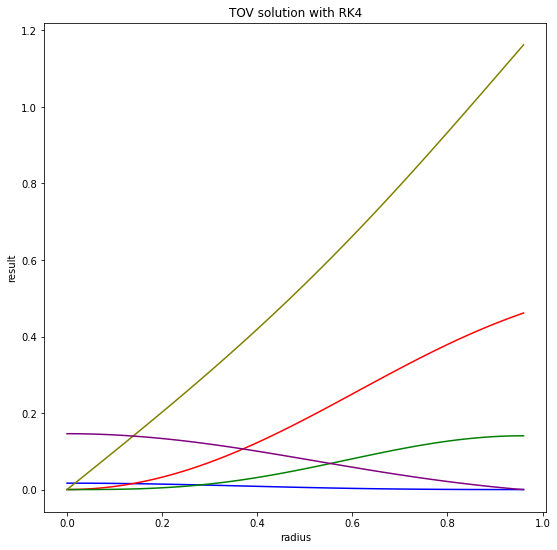

In [118]:
#Testing Box

#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []
calculatedList4 = []

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[5]))
        calculatedList2.append(float(row[7]))
        calculatedList3.append(float(row[9]))
        calculatedList4.append(float(row[11]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('TOV solution with RK4')
ax.plot(positionList, calculatedList0, color='b') 
ax.plot(positionList, calculatedList1, color='r') 
ax.plot(positionList, calculatedList2, color='g') 
ax.plot(positionList, calculatedList3, color='olive') 
ax.plot(positionList, calculatedList4, color='purple') 

#plt.ylim(0.0,0.15)
#plt.xlim(0.0,1)
fig.set_size_inches(9,9)

Well, everything looks nice and smooth, but a lot of the information here is condensed at the bottom of the graph. Let's zoom in to examine the detail. 

(For the record, blue is pressure, red is nu, green is mass, gold is r-bar, and purple is total energy density) 

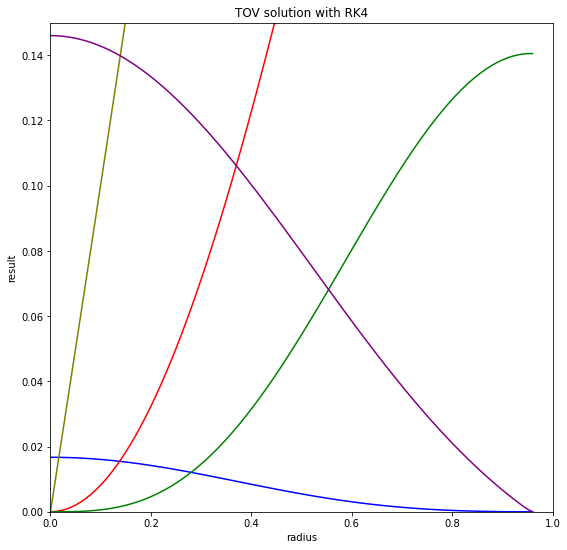

In [119]:
#Testing Box

#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []
calculatedList4 = []

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[5]))
        calculatedList2.append(float(row[7]))
        calculatedList3.append(float(row[9]))
        calculatedList4.append(float(row[11]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('TOV solution with RK4')
ax.plot(positionList, calculatedList0, color='b') 
ax.plot(positionList, calculatedList1, color='r') 
ax.plot(positionList, calculatedList2, color='g') 
ax.plot(positionList, calculatedList3, color='olive') 
ax.plot(positionList, calculatedList4, color='purple') 

plt.ylim(0.0,0.15)
plt.xlim(0.0,1)
fig.set_size_inches(9,9)

From this, we can confirm that our termination condition is working: the number of steps would have taken us to r=1, but we stop slightly before that. We also don't have any NaNs

((More analysis goes here))

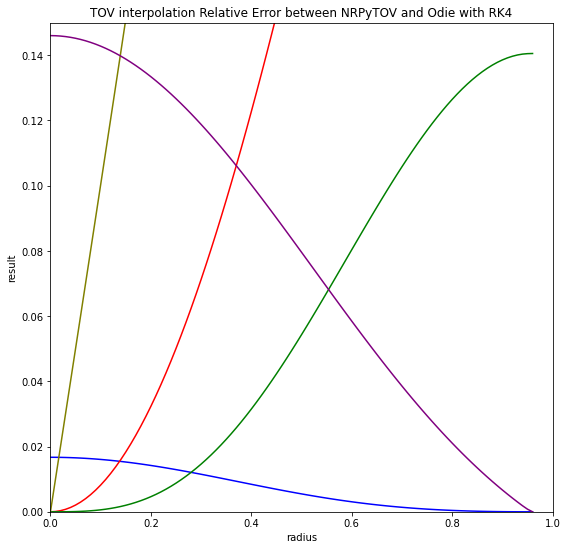

In [86]:
#Testing Box

#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []


# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/outputTOVpolytrope.txt') as f: 
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('TOV interpolation Relative Error between NRPyTOV and Odie with RK4')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 

# setting size was annoying.
fig.set_size_inches(9,9)

#Testing Box

#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []


# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[11]))

R_Schw    = 9.566044579232513e-01
M         = 1.405030336771405e-01
Rbar_Schw = 1.157461364e+00#8.100085557410308e-01

# C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw

# interpolatedList0 = np.interp(apositionList, positionList, np.array(calculatedList0))

# ax.plot(apositionList, abs(2.0*(interpolatedList0-np.array(acalculatedList0))/(abs(interpolatedList0) + abs(np.array(acalculatedList0)))), color='b') 

# interpolatedList2 = np.interp(apositionList, positionList, np.array(calculatedList2))

# ax.plot(apositionList, abs(2.0*(interpolatedList2-np.array(acalculatedList2))/(abs(interpolatedList2) + abs(np.array(acalculatedList2)))), color='g') 

ax.plot(apositionList, acalculatedList0, color='b') 
ax.plot(apositionList, acalculatedList1, color='r') 
ax.plot(apositionList, acalculatedList2, color='g') 
ax.plot(apositionList, acalculatedList3, color='olive') 
ax.plot(apositionList, acalculatedList4, color='purple') 

#ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList0))-np.array(acalculatedList0), color='b')
#ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList2))-np.array(acalculatedList2), color='g')
#ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList3))-np.array(acalculatedList3)*C, color='olive')
#ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList1))-np.array(acalculatedList4), color='purple')

# ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList2))-np.array(acalculatedList2), color='g') 

# ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList3))-np.array(acalculatedList3)*C, color='olive') 

# ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList1))-np.array(acalculatedList4), color='purple') 



# ax.plot(apositionList, apositionList, color='k') 

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
plt.ylim(0.0,0.15)
plt.xlim(0.0,1)
fig.set_size_inches(9,9)

<a id='S4a'></a>

## Step 4a: Customization \[Back to [top](#toc)\]
$$\label{S4a}$$

#### Wealth, fame, power, accuracy... all of it is on offer for the right combination of settings.

Here is where users can adjust information in the notebook to adjust how the program runs. This will change the Results section, but not Expanded Results, which uses data from previous runs that will not change. 

In [12]:
#This is the method variable, used to choose how the program calculates the result. 
key = "RK4"
#Possible options: "Euler" (Order 1), "RK2 Heun" (Order 2), "RK2 MP" (2), 
#"RK2 Ralston" (2), "RK3" (3), "RK3 Heun" (3), "RK3 Ralston" (3), "SSPRK3" (3),
#"RK4" (4), "DP5" (5), "DP5alt" (5), "CK5" (5), "DP6" (6), "L6" (6), "DP8" (8) 

#This is the step size. 
step = "0.01"
#Can be any number, 0.01 by default. Note that this is a string--we are passing it to
#the C code generator as a string. Be very sure not to declare it as something that isn't
#a number. 

#This is the number of steps.
size = "100"
#Can be any integer, 1000 by default. Be sure to make it actually be an integer. 

#more coming eventually: functions and boundary values.
#though those two might be a while. 

<a id='S4b'></a>

## Step 4b: Python-Code \[Back to [top](#toc)\]
$$\label{S4b}$$

#### Can't do anything if there's nothing to do it with!

Naturally, one does not just automatically push a Python-codified Butcher table into a C-code. We have to actually grab it and format the Butcher Table in such a way that it can be understood. Which means formatting a string into a C-command based on the provided Butcher Tables from NRPy. 

In [13]:
import sympy as sp              # SymPy: The Python computer algebra package upon which NRPy+ depends
import numpy as np              # NumPy: A numerical methods module for Python
from RK_Butcher_Table_Dictionary import Butcher_dict #the Butcher Tables themselves. 

#The end result of all this should be a string with our chosen method. 
#If you want to set the method, see above. 

butcherTable = ""

#Now in order to determine what size to make our loop, we need the size of the table itself.
print(len(Butcher_dict[key][0]))
rows = len(Butcher_dict[key][0])
i = 0

#Set up th edeclaration of the double 2D array in C. 
butcherTable = butcherTable + "double butcher[" + str(len(Butcher_dict[key][0])) + "][" + str(len(Butcher_dict[key][0])) +"] = {"

while (i < rows):
    print(len(Butcher_dict[key][0][i]))
    #The above print function helps us see that the program really is doing the entire matrix.
    columns = len(Butcher_dict[key][0][i])
    butcherTable = butcherTable + "{"
    #Even though the matrix is square, we cannot set rows=columns since 
    #The butcher tables have a lot of empty slots we will be filling with 0s. 
    j = 0
    if Butcher_dict[key][0][i][j] == '':
        butcherTable = butcherTable + str(float(Butcher_dict[key][1]))+ ","
        j = j+1
        # This is a check for the empty spot in the bottom left of the table
        # the C-code uses this to store the method order, so we put it there. 
        # The main bennefit is that this keeps the matrix square.
    while (j < rows): #not < columns, since we still need to fill in 0s for 
        #the C code. 
        if (j < columns):
            butcherTable = butcherTable + str(float(Butcher_dict[key][0][i][j]))
            # Print the number requested. 
            # Note the conversion to floating point. The C-code has no clue what to
            # do with fractions, so they must be changed. 
            if (j<rows-1):
                butcherTable = butcherTable + ","
                #if not at end of row, add comma. WE don't want to overdo it. 
        elif (j < rows-1):
            butcherTable = butcherTable + "0"+ ","
            # if we are at the point where there are no numbers, fill with 0. 
        else:
            butcherTable = butcherTable + "0"
            # if we are at the point where there are no numbers, fill with 0. 
            # end of row does not have the comma addition. 
        j = j+1
    if(i < rows-1):
        butcherTable = butcherTable + "},"
    else:
        butcherTable = butcherTable + "}"
    # After every row, we need a brace, but the added comma is not needed on the last one.
    i = i+1
butcherTable = butcherTable + "};"
print(butcherTable)



5
1
2
3
4
5
double butcher[5][5] = {{0.0,0,0,0,0},{0.5,0.5,0,0,0},{0.5,0.0,0.5,0,0},{1.0,0.0,0.0,1.0,0},{4.0,0.16666666666666666,0.3333333333333333,0.3333333333333333,0.16666666666666666}};


With that, now we can start setting up the file within which we will run the C code. Now we can actually use some functionality form NRPy+ proper! NRPy+ is designed to use Python to generate C codes. To do this, we start by creating the directory. 

In [14]:
import outputC as outC       #NRPy+: Core C code output module.
import cmdline_helper as cmd #NRPy+: Multi-platform Python command-line interface
import os                    #Python: Miscellaneous operating system interfaces
import shutil                #Python: High level file operations

# https://github.com/zachetienne/nrpytutorial/blob/master/Tutorial-Start_to_Finish-Finite_Difference_Playground.ipynb

#Create a C code output directory
#First, name it.
Ccodesrootdir = os.path.join("ODESolver_Ccodes/")
#Remove any previously existing files there.
shutil.rmtree(Ccodesrootdir,ignore_errors=True)
#Create the fresh directory. 
cmd.mkdir(Ccodesrootdir)

Now that we have the directory, the primary way in which NRPy+ generated C-codes is by creating a function that adds the C-code to an internal C-function dictionary. Most of it is occupied by C-code, so... 

<a id='S4c'></a>

## Step 4c: C-Code \[Back to [top](#toc)\]
$$\label{S4c}$$

#### Behold, the solver. 

Below is the C-Code. Numerous output lines are commented out and can be un-commented at will if a user wishes to examine in more detail what's happening during runtime. (Though in this notebook that is likely not necessary as the terminal output is just placed in a text file.) Code is heavily commented, some of it is likely redundant with the section above, but looking at things two different ways rarely hurts. 

The C-code generated here can also be found in pure C form, though it only has one of each of the first five orders of solution methods as possibilities. 

In [15]:
#now define our c function itself.
def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h", "time.h"]
    # what "#include" lines do we include at the top?
    
    prefunc = r"""
    double diffyQEval (double x, double y[], int i)
    {
        switch(i){
            case 0: {
                return y[1]; 
                //we use 0 to represent the answer we eventually want to get
                //in this case, the solution to y'' = y+x, stated here as y'=z
                break;
            }
            case 1: {
                return y[0] + x;
                //1 represents the first derivative. y''=y+x, but when we split it up we got y'=z. This equation returns the value
                //for the z derivative, z'=y+x
                break;
            }
            // case...
            //add more cases for higher order systems. 
            default: {
                //Any number could be a result, theoretically, so there isn't an easy error value to put here.
            }
        }
        //This is the differential equation system itself. 
        //By default we have a very simple y'' = y+x situation here, split up into
        // y[0]' = y[1]
        // y[1]' = y[0]+x
        //Naturally other equaitons can be put in, but be sure to change the numberOfEquations value!
        //feel free to change the return values to other functions. 
        //Note: not guaranteed to work for functions that are not well-behaved. 
        //We have this set up so y[0] would be the final "answer" for a split-up higher-order ODE. 
    }

    //This is the function to evaluate the known solution. Must be set manually.
    double knownQEval (double x)
    {
        return exp(x) + exp(-x) - x;
        //the known solution to the differential equaiton, specifically what we call y[0]
        //used to measure relative errors. 
        //"exp(x) + exp(-x) - x" is "default." as it is the answer to the differential equation we chose. 
        //Do note that this would change with different boundary conditions. 
    }
    """
    #prefunctions are functions declared outside main. In this case, we have the 
    #differential equation and the known exact solution. 
    
    desc = "Fill out later"
    #just put a guide as to what the code actually does here. 
    
    c_type = "int" 
    #what does main return?
    
    name = "main"
    #will almost always just be "main", but could be otherwise. 
    
    params = ""
    #various paremeters. Should be "" most often. 
    
    #Below is where the actual main function itself goes, constructed from the variables
    #defined in the customization section.
    body = butcherTable + r"""
    printf("Beginning ODE Solver \"Odie\" V4...\n");
    
    //SECTION I: Preliminaries
    //Before the program actually starts, variables need to be created
    //and set, as well as the function itself chosen. 
    //The diffyQ itself can be found declared in diffyQEval().

    //How to get array size: https://stackoverflow.com/questions/37538/how-do-i-determine-the-size-of-my-array-in-c
    size_t methodSize = sizeof(butcher)/sizeof(butcher[0][0]);
    int dimension = sqrt((int)methodSize);
    printf("Method Order: %i. \nOrder of Error should be near Method Order + 1.\n",(int)butcher[dimension-1][0]);
    printf("If not, try a larger step size, roundoff error may be interfering.\n");

    double step = """ + step + r"""; //the "step" value.
    double bound = 0.0; //where the boundary/initial condition is.
    int numberOfEquations = 2; //How many equations are in our system?
    //Be very careful setting these boundary conditions, they need to match the number of equations. 
    double bValue[numberOfEquations]; 
    bValue[0] = 2.0;
    bValue[1] = -1.0;
    //the value at y(bound). By default we say y(0) = 0.
    const int SIZE = """ + size + r"""; //How many steps we are going to take?
    bool validate = true; //set to true if you wish to run a validation test.
    //Attempts to find the order of the method used. 

    double y1[numberOfEquations];
    double y2[numberOfEquations];
    double yTruth1;
    double yTruth2;
    double yError;
    //These variables temporarily store the values calculated before they are 
    //printed to the output file and forgotten. 
    //y is what we solve for, yTruth is the "known results."
    //yError is the error of y when compared to yTruth
    //Should be able to handle any size, unlike arrays, which just hog memory. 
    //Errors and Truth are not arrays as they are only concerned with the final value. 

    for (int n = 0; n < numberOfEquations; n++) {
        y1[n] = bValue[n];
        //Assign the initial values to the boundary conditions. 
    } 
    yTruth1 = knownQEval(bound);
    yError = 0; //has to be zero as they must match at this point. 
    //If not, the boundary conditions were not stated properly. 

    double saveErr1=0, saveErr2=0; //variables for validation if requested. 
    
    //SECTION II: The Loop

    //prior to beginning the loop, start the timer. 
    double startN = time(NULL);
    //printf("Time: %.90f seconds\n", startN);
    //set start time to current time.  Uncomment to print.

    //also open the file we'll be writing data to. 
    FILE *fp;
    fp = fopen("oData.txt","w");

    //This loop fills out all the data.
    //It takes a provided butcher table and executes the method stored within. Any table should work. 
    printf("INITIAL: Position:\t%f\tTruth:\t%10.9e\tCalculated:\t%10.9e\tError:\t%10.9e\t\n",bound,yTruth1, y1[0], yError);
    fprintf(fp,"Position:,\t%f,\tTruth:,\t%10.9e,\tCalculated:,\t%10.9e,\tError:,\t%10.9e,\t\n",bound,yTruth1, y1[0], yError);
    //Comma delimiters are printed to the file so it can be converted to .csv with ease. 
    
    for (int i = 0; i < SIZE; i++){ 
        //printf("%i",m);
        double K[dimension][numberOfEquations];
        //Since we'll be calling this while it's empty, even though there should be no errors due
        //to the way it's set up, let's go ahead and fill it with zeroes.
        for (int j = 0; j<dimension; j++) {
            for (int n = 0; n<numberOfEquations; n++) {
                K[j][n]=0.0;
            }
        }
        //each diffyQ has its own set of K-values, one for each equation. 

        double yInsert[numberOfEquations];
        //We also need an array for the inserted y-values for each equation. 
        //Most applications actually have the different yInsert values be independent, so 
        //if we knew the form of the equation we could simplify the code.
        //However, we need to make sure to always fill everything in case we have a system
        //of the form y'=f(u,y) u'=g(u,y)

        for (int j = 1; j < dimension; j++) {
            //Due to the way the Butcher Table is formatted, start our index at 1 and stop at the end. 
            double xInsert = bound+i*step + butcher[j-1][0]*step;
            //x does not change much for different tables, just adjust the "step correction" term.
            //Is the same for every equation too.

            for (int n = 0; n < numberOfEquations; n++) {
                yInsert[n] = y1[n];
            } 

            for (int n = 1; n < dimension; n++) {
                //Once again, start at index of 1 rather than 0.
                for (int q = 0; q < numberOfEquations; q++) {
                    yInsert[q] = yInsert[q] + butcher[j-1][n]*K[n][q];
                }
                //Each individual y portion is dependent on one of the K values.
                //K values are initially set to zero even though technically whenever 
                //we would use an undeclared K-value the butcher table would have zero.
                //You know, just in case something goes wrong. 
            }

            for (int n = 0; n < numberOfEquations; n++) {
                K[j][n] = step*diffyQEval(xInsert,yInsert,n);
                //Actually calculate the K-values.
            } 

        }
        //Now that we have all the K-values set, we need to find the actual result in one final loop.
        //The sum for the first set... 
        for (int n = 0; n< numberOfEquations; n++) {
            K[0][n] = y1[n];
            for (int j = 1; j < dimension; j++) {
                K[0][n] = K[0][n] + butcher[dimension-1][j]*K[j][n];
            }
            y2[n] = K[0][n];
        }
        
        yTruth2 = knownQEval(bound+step*(i+1));
        yError = (yTruth2 - y2[0]);

        //After each step is calculated, print results. 
        //printf("Position:\t%f\tTruth:\t%10.9e\tCalculated:\t%10.9e\tError:\t%10.9e\t\n",bound+(i+1)*step,yTruth2, y2, yError);
        //uncomment if you want live updates. 
        //if (m==0) {
            fprintf(fp,"Position:,\t%f,\tTruth:,\t%10.9e,\tCalculated:,\t%10.9e,\tError:,\t%10.9e,\t\n",bound+(i+1)*step,yTruth2, y2[0], yError);
        //}
                
        //validation: grab the first nonzero error, calculate its order.
        //Currently broken. 
        if(validate==true && i == 0.0) { //currently set to ignore this. REMEMBER TO TURN BACK ON LATER!
            //Only activate on first step. 
            saveErr1 = yError;

            //The following is an algorithm for determining the rate of error 
            //convergence. A bit rudimentary, could be condensed, but is also only
            //called once so not relaly a concern and it is easier to read this way. 
            double step2 = step*0.5;
            //It is easier to just use another variable than multiply the step by 0.5 every time. 
                for (int j = 0; j<dimension; j++) {
                    for (int n = 0; n<numberOfEquations; n++) {
                        K[j][n]=0.0;
                    }
                }
                for (int j = 1; j < dimension; j++) {
                    double xInsert = bound+i*step2 + butcher[j-1][0]*step2;
                    for (int n = 0; n < numberOfEquations; n++) {
                        yInsert[n] = y1[n];
                    } 
                    for (int n = 1; n < dimension; n++) {
                        for (int q = 0; q < numberOfEquations; q++) {
                            yInsert[q] = yInsert[q] + butcher[j-1][n]*K[n][q];
                        }
                    }
                    for (int n = 0; n < numberOfEquations; n++) {
                        K[j][n] = step2*diffyQEval(xInsert,yInsert,n);
                    } 
                }
                for (int n = 0; n< numberOfEquations; n++) {
                    K[0][n] = y1[n];
                    for (int j = 1; j < dimension; j++) {
                        K[0][n] = K[0][n] + butcher[dimension-1][j]*K[j][n];
                    }
                }
            double truthValidate = knownQEval(bound+step2);
            saveErr2 = (truthValidate - K[0][0]);
            //Basically we just calculated the initial error for half step size. 
            //Now we can compare using the equation for order estimation:
            double order =  log2(saveErr1/saveErr2);
            printf("Order of Error: %f\n", order);
        }
        
        for (int n = 0; n < numberOfEquations; n++) {
            y1[n]=y2[n];
        } 
        //make sure to assign all variables to the next step. 
        yTruth1=yTruth2;
         
    }

    //SECTION III: Analysis
    //Post-processing goes here.

    // basic reference: https://www.tutorialspoint.com/cprogramming/c_file_io.htm
    // used to be a file converter here, now there isn't, we just close the file. 
    fclose(fp);

    //TIMER
    double endN = time(NULL);
    //loop is complete, how long did it take?
    printf("Time Elapsed: %f seconds\n", endN-startN);
    //Only calculates to the closest second, for some reason.

    printf("ODE Solver \"Odie\" V4 Shutting Down...\n");
    return 0;

// - GM, master of dogs.
    """
    
    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)
    #Now all those things we defined above are put into a function from outC, 
    #Which generates the actual entry in the C function dictionary. 
    
add_to_Cfunction_dict_ODESolver()
# Call the function we just declared above. 

cmd.new_C_compile(Ccodesrootdir, "ODESolver", compiler_opt_option="fast")
#This just compiles the code into the file ODESolver. 

os.chdir(Ccodesrootdir)
#Change the file path to the folder we created earlier. 

cmd.Execute("ODESolver", "", "terminalOutput.txt")
#Evaluate the C-code and put the Terminal output into a text file. 

(EXEC): Executing `make -j10`...
main.c: In function ‘diffyQEval’:
main.c:36:5: warning: control reaches end of non-void function [-Wreturn-type]
   36 |     }
      |     ^
(BENCH): Finished executing in 0.20 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3 ./ODESolver `...
(BENCH): Finished executing in 0.21 seconds.


References in the code above are 

[1](#1) https://en.wikibooks.org/wiki/C_Programming/time.h

[2](#2) https://askubuntu.com/questions/332884/how-to-compile-a-c-program-that-uses-math-h

[3](#3) https://www.tutorialspoint.com/cprogramming/c_file_io.htm

[4](#4) Numerical Mathematics and Computing 6E by Cheney and Kincaid

[8](#8) https://stackoverflow.com/questions/37538/how-do-i-determine-the-size-of-my-array-in-c 

So, what do we get when we run this code? Well...

<a id='S4d'></a>

## Step 4d: Results \[Back to [top](#toc)\]
$$\label{S4d}$$

#### If it isn't the consequences of my own actions

First, let's see what the terminal printed. 

In [16]:
with open("terminalOutput.txt") as f:
    print(f.read())

Beginning ODE Solver "Odie" V4...
Method Order: 4. 
Order of Error should be near Method Order + 1.
If not, try a larger step size, roundoff error may be interfering.
INITIAL: Position:	0.000000	Truth:	2.000000000e+00	Calculated:	2.000000000e+00	Error:	0.000000000e+00	
Order of Error: -nan
Time Elapsed: 0.000000 seconds
ODE Solver "Odie" V4 Shutting Down...



Was the order of error roughly equal to the method error plus 1? It should be, though if it's much larger than that it's not a big concern, as it is perfectly fine for a method to be more accurate than predicted.

If the result spat out a bunch of inf or nan values for Order of Error, it likely means the method was "too accurate" to get good error readings, in which case why not try a smaller step size if you really want to validate that the method itself is working properly? 

The time.h program only does whole seconds for now, so all we can say is that it took less than 1 second. 

The actual data produced by the program is below. Note: if you chose a large SIZE it will be a very long result. 

In [17]:
with open("oData.txt") as f:
    print(f.read())

Position:,	0.000000,	Truth:,	2.000000000e+00,	Calculated:,	2.000000000e+00,	Error:,	0.000000000e+00,	
Position:,	0.010000,	Truth:,	1.990100001e+00,	Calculated:,	1.990100001e+00,	Error:,	2.664535259e-15,	
Position:,	0.020000,	Truth:,	1.980400013e+00,	Calculated:,	1.980400013e+00,	Error:,	3.907985047e-14,	
Position:,	0.030000,	Truth:,	1.970900068e+00,	Calculated:,	1.970900068e+00,	Error:,	1.083577672e-13,	
Position:,	0.040000,	Truth:,	1.961600213e+00,	Calculated:,	1.961600213e+00,	Error:,	2.113864639e-13,	
Position:,	0.050000,	Truth:,	1.952500521e+00,	Calculated:,	1.952500521e+00,	Error:,	3.474998067e-13,	
Position:,	0.060000,	Truth:,	1.943601080e+00,	Calculated:,	1.943601080e+00,	Error:,	5.169198403e-13,	
Position:,	0.070000,	Truth:,	1.934902001e+00,	Calculated:,	1.934902001e+00,	Error:,	7.200906538e-13,	
Position:,	0.080000,	Truth:,	1.926403414e+00,	Calculated:,	1.926403414e+00,	Error:,	9.565681580e-13,	
Position:,	0.090000,	Truth:,	1.918105469e+00,	Calculated:,	1.918105469e+00,	Error:

And those are the results in raw form. Below are some graphs generated from the data produced. 

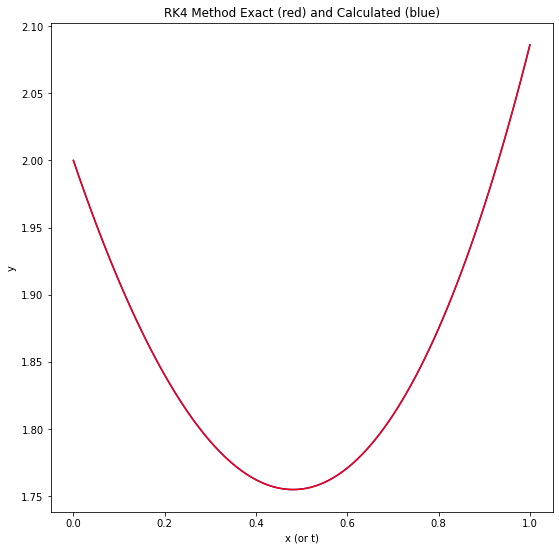

In [18]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
truthList = []
calculatedList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oData.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        truthList.append(float(row[3]))
        calculatedList.append(float(row[5]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title(key + ' Method Exact (red) and Calculated (blue)')
ax.plot(positionList, truthList, color='b')
ax.plot(positionList, calculatedList, color='r')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'

For most methods you likely won't see a difference between exact and calculated, so it's often better to examine the error directly. 

[9](#9) https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine

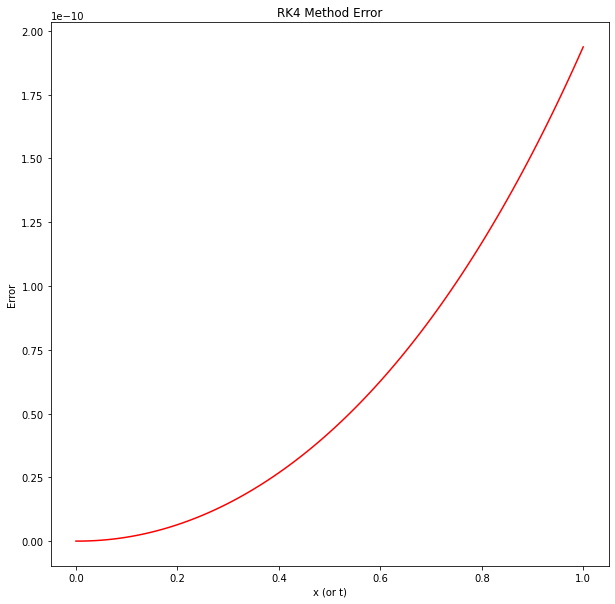

In [19]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
errorList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('oData.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        errorList.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Error')
ax.set_title(key + ' Method Error')
ax.plot(positionList, errorList, color='r')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(10,10)

We often care more about error closer to the start point, so a logarithmic plot is often more illuminating as to how the error actually goes. 

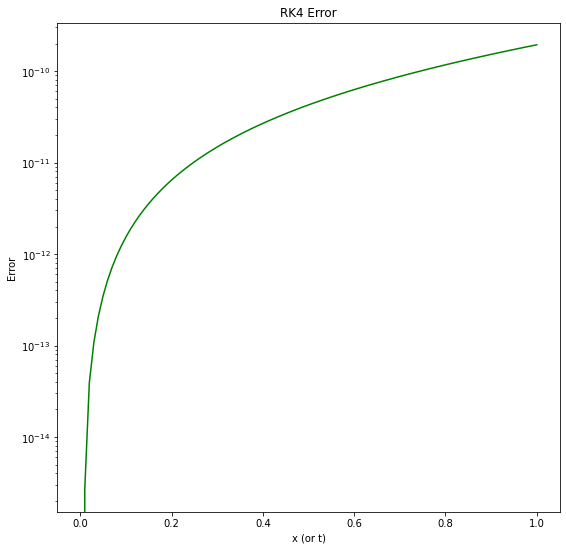

In [20]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
errorList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('oData.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        errorList.append(abs(float(row[7])))
        #remember to absolute value for log plots, otherwise negative values
        #shoot off the deep end.

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Error')
ax.set_title(key + ' Error')
ax.plot(positionList, errorList, color='g')
ax.set_yscale("log") #found in matplotlib's documentation.
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(9,9)

And an even better measure of the error would be the relative error, where we divide the error by the exact value. 

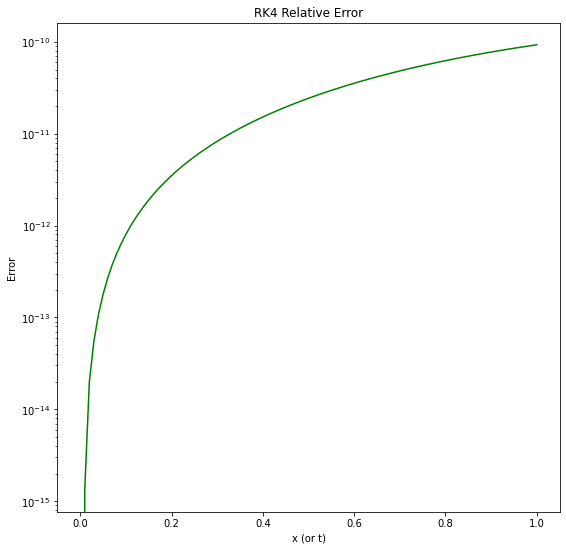

In [21]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
errorList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('oData.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        errorList.append(abs(float(row[7]) / (float(row[3])+0.00000000000000001)))
        #that tiny number is added to prevent division by zero
        #it always occurs on the first step, and can occur later when exact answers arise.

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Error')
ax.set_title(key + ' Relative Error')
ax.plot(positionList, errorList, color='g')
ax.set_yscale("log") #found in matplotlib's documentation.
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(9,9)

For reasons unknown matplotlib has issues plotting the logarithmic scale of an arbitrary set of data, working on it. Likely because it stays within one order of magnitude. 

Regardless, here's the relative error without the log scale.

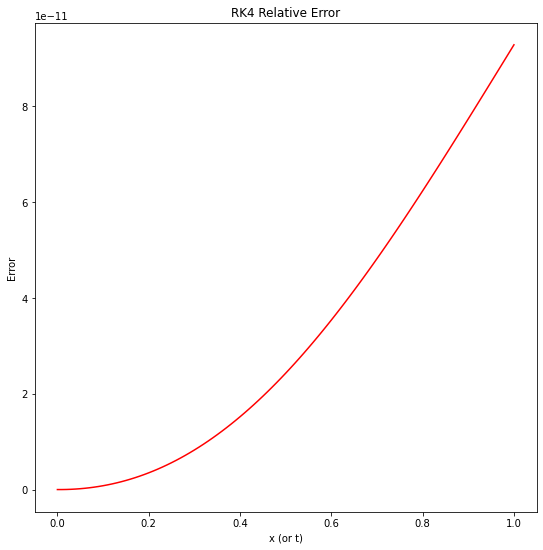

In [22]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
errorList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('oData.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        errorList.append(float(row[7]) / (float(row[3])+0.00000000000000001))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Error')
ax.set_title(key + ' Relative Error')
ax.plot(positionList, errorList, color='r')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(9,9)

<a id='S5'></a>

# Step 5: Additional Analysis \[Back to [top](#toc)\]
$$\label{S5}$$


#### A truly absurd number of graphs awaits

Now, understandably, we might want to analyze the larger-scale behavior of the program, and depending on what the user input at the start of this notebook is that could change (or even break!). So, for discussion, we use previous runs of the code on the ODE u'' = u+x.

To start, Euler's method produces:

```
Beginning ODE Solver "Odie" V4...
Method Order: 1. 
Order of Error should be near Method Order + 1.
If not, try a larger step size, roundoff error may be interfering.
INITIAL: Position:	0.000000	Truth:	2.000000000e+00	Calculated:	2.000000000e+00	Error:	0.000000000e+00	
Order of Error: 2.000009
Time Elapsed: 0.000000 seconds
ODE Solver "Odie" V4 Shutting Down...
```

Note that the order of error is about 2, as expected. Note that it reports "0 seconds". The time.h program only does whole seconds for now, so all we can say is that it took less than 1 second. 

And the actual data itself is:

```
Position:,	0.000000,	Truth:,	2.000000000e+00,	Calculated:,	2.000000000e+00,	Error:,	0.000000000e+00,	
Position:,	0.010000,	Truth:,	1.990100001e+00,	Calculated:,	1.990000000e+00,	Error:,	1.000008333e-04,	
Position:,	0.020000,	Truth:,	1.980400013e+00,	Calculated:,	1.980200000e+00,	Error:,	2.000133335e-04,	
Position:,	0.030000,	Truth:,	1.970900068e+00,	Calculated:,	1.970600000e+00,	Error:,	3.000675020e-04,	
Position:,	0.040000,	Truth:,	1.961600213e+00,	Calculated:,	1.961200020e+00,	Error:,	4.001933447e-04,	
Position:,	0.050000,	Truth:,	1.952500521e+00,	Calculated:,	1.952000100e+00,	Error:,	5.004208767e-04,	
Position:,	0.060000,	Truth:,	1.943601080e+00,	Calculated:,	1.943000300e+00,	Error:,	6.007801276e-04,	
Position:,	0.070000,	Truth:,	1.934902001e+00,	Calculated:,	1.934200700e+00,	Error:,	7.013011462e-04,	
Position:,	0.080000,	Truth:,	1.926403414e+00,	Calculated:,	1.925601400e+00,	Error:,	8.020140056e-04,	
Position:,	0.090000,	Truth:,	1.918105469e+00,	Calculated:,	1.917202520e+00,	Error:,	9.029488084e-04,	
Position:,	0.100000,	Truth:,	1.910008336e+00,	Calculated:,	1.909004200e+00,	Error:,	1.004135692e-03	

```

We can easily construct similar data for any other Butcher Table. Here is RK4. 

```
Beginning ODE Solver "Odie" V4...
Method Order: 4. 
Order of Error should be near Method Order + 1.
If not, try a larger step size, roundoff error may be interfering.
INITIAL: Position:	0.000000	Truth:	2.000000000e+00	Calculated:	2.000000000e+00	Error:	0.000000000e+00	
Order of Error: 6.000189
Time Elapsed: 0.000000 seconds
ODE Solver "Odie" V4 Shutting Down...
```
Note that the order of error given is 6, not 5. This is usually because we have solution that doesn't have a 5th order term in the Taylor Expansion. 

```
Position:,	0.000000,	Truth:,	2.000000000e+00,	Calculated:,	2.000000000e+00,	Error:,	0.000000000e+00,	
Position:,	0.100000,	Truth:,	1.910008336e+00,	Calculated:,	1.910008333e+00,	Error:,	2.778273611e-09,	
Position:,	0.200000,	Truth:,	1.840133511e+00,	Calculated:,	1.840133472e+00,	Error:,	3.898120737e-08,	
Position:,	0.300000,	Truth:,	1.790677028e+00,	Calculated:,	1.790676919e+00,	Error:,	1.091940054e-07,	
Position:,	0.400000,	Truth:,	1.762144744e+00,	Calculated:,	1.762144529e+00,	Error:,	2.146787335e-07,	
Position:,	0.500000,	Truth:,	1.755251930e+00,	Calculated:,	1.755251573e+00,	Error:,	3.573925431e-07,	
Position:,	0.600000,	Truth:,	1.770930436e+00,	Calculated:,	1.770929896e+00,	Error:,	5.400162870e-07,	
Position:,	0.700000,	Truth:,	1.810338011e+00,	Calculated:,	1.810337245e+00,	Error:,	7.659938797e-07,	
Position:,	0.800000,	Truth:,	1.874869893e+00,	Calculated:,	1.874868853e+00,	Error:,	1.039582946e-06,	
Position:,	0.900000,	Truth:,	1.966172771e+00,	Calculated:,	1.966171405e+00,	Error:,	1.365917402e-06,	
Position:,	1.000000,	Truth:,	2.086161270e+00,	Calculated:,	2.086159519e+00,	Error:,	1.751082823e-06,		
```

Note how the error gets much, much smaller the higher the order of the calculation method. RK4 was so good that the step size 0.01 breaks the validation checker since it's so accurate! 

Below this, we make a large number of graphs, including those made from multiple runs of the program.

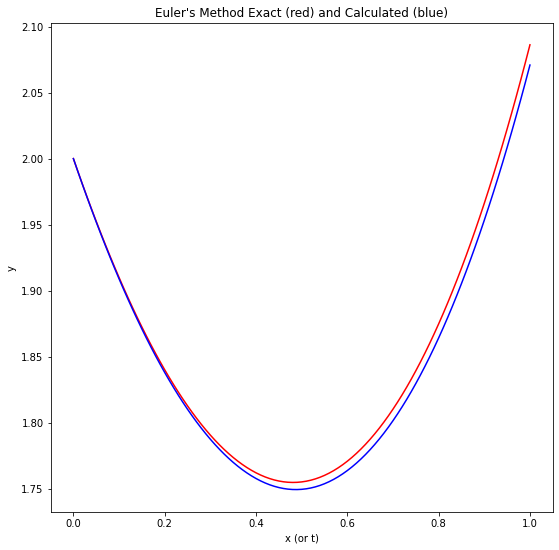

In [23]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
truthList = []
calculatedList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/EulerData1.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        truthList.append(float(row[3]))
        calculatedList.append(float(row[5]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title('Euler\'s Method Exact (red) and Calculated (blue)')
ax.plot(positionList, truthList, color='r')
ax.plot(positionList, calculatedList, color='b') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'

[5](#5) NRPy+ "Solving the Scalar Wave Equation"

[6](#6) https://www.dataquest.io/blog/read-file-python/

[7](#7) https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib

We note that the two lines are rather close, even for the least accurate method we have. The calculated value clearly gets less accurate over time. Higher order methods have no visible difference at this scale, as we can see with RK4 below. 

In [24]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
truthList = []
calculatedList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open(sys.path[0] + '/oData.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        truthList.append(float(row[3]))
        calculatedList.append(float(row[5]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title('RK4 Exact (red) and Calculated (blue)')
ax.plot(positionList, truthList, color='b')
ax.plot(positionList, calculatedList, color='r') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'

ValueError: could not convert string to float: '\tEquation 0:'

Since it's so hard to see anything interesting in these graphs, instead of plotting the results next to each other, let us plot the errors directly. 

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
errorList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open(sys.path[0] + '/EulerData1.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        errorList.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Error')
ax.set_title('Euler\'s Method Error')
ax.plot(positionList, errorList, color='r')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(10,10)

The shape of the other methods is virtually identical in all except for amplitude. Errors grow with time, as should be expected, for every error adds to the error of the next step. Let us examine the RK4 error...

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
errorList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open(sys.path[0] + '/RK4Data1.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        errorList.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Error')
ax.set_title('RK4 Method Error')
ax.plot(positionList, errorList, color='r')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(10,10)

One may note the similar shape of these graphs, but that their *scale* is different. RK4 is orders of magnitude different from Euler's in terms of error, even if the error behaves the same in each of them. If we compare to the actual true calculated value, Euler's method is off by 1/100th by the time we reach x=1 and RK4 by 1/10,000,000,000th.

Now, our order checker sometimes has difficulty with higher-accuracy methods. There is a second way we can check for proper error order, though it involves eyeballing a graph rather than getting out a specific number. To do this, we need to run another test at a different step size, specifically half. 

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
positionList2 = []
error1List = []
error2List = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open(sys.path[0] + '/EulerData2.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        error1List.append(abs(float(row[7])/(float(row[3])+0.000000000000001)))
        
with open(sys.path[0] + '/EulerData1.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList2.append(float(row[1]))
        error2List.append(abs(float(row[7])/(float(row[3])+0.000000000000001)))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error [(Exact-Calculated)/Exact]')
ax.set_title('Euler\'s Method 0.005-Step (red) and 0.01-Step (blue)')
ax.plot(positionList, error1List, color='r')
ax.plot(positionList2, error2List, color='b') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
plt.xlim(0.0,0.5)
ax.set_yscale("log") #found in matplotlib's documentation.

fig.set_size_inches(5,5)
fig.title = 'Title'

Ignoring the "early weirdness," these two errors are clearly related.

Now, the error we are comparing here is not first-step order, it is error at any time step. This error will be EQUAL to the order of the method, not equal to it plus 1, since the error compounds in such a way that it is multiplied by the number of steps, which is effectively dividing by 1/step, lowering the order of the error to the method order. To demonstrate this, let us divide the values of the blue data by 2 (which is first order error, 2^1).

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
positionList2 = []
error1List = []
error2List = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open(sys.path[0] + '/EulerData2.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        error1List.append(abs(float(row[7])/(float(row[3])+0.000000000000001)))
        
with open(sys.path[0] + '/EulerData1.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList2.append(float(row[1]))
        error2List.append(abs(float(row[7])/(float(row[3])+0.000000000000001))/2.0)

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error [(Exact-Calculated)/Exact]')
ax.set_title('Euler\'s Method 0.005-Step (red) and 0.01-Step (blue)')
ax.plot(positionList, error1List, color='r')
ax.plot(positionList2, error2List, color='b') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
plt.xlim(0.0,0.5)
ax.set_yscale("log") #found in matplotlib's documentation.

fig.set_size_inches(5,5)
fig.title = 'Title'

And they match! Exactly as they should. We can do a similar thing with RK4, but notably the division will be ($2^4 = 16$).

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
positionList2 = []
error1List = []
error2List = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open(sys.path[0] + '/RK4Data2.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        error1List.append(abs(float(row[7])/(float(row[3])+0.000000000000001)))
        
with open(sys.path[0] + '/RK4Data1.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList2.append(float(row[1]))
        error2List.append(abs(float(row[7])/(float(row[3])+0.000000000000001)))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error [(Exact-Calculated)/Exact]')
ax.set_title('RK4 Method 0.005-Step (red) and 0.01-Step (blue)')
ax.plot(positionList, error1List, color='r')
ax.plot(positionList2, error2List, color='b') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
plt.xlim(0.0,0.5)
ax.set_yscale("log") #found in matplotlib's documentation.

fig.set_size_inches(5,5)
fig.title = 'Title'

In [ ]:
#Testing Box

#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []


# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/oData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[5]))
        calculatedList2.append(float(row[7]))
        calculatedList3.append(float(row[9]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title('Hasty Euler\'s Method TOV evolution with non-Junk')
ax.plot(positionList, calculatedList0, color='b') 
       
ax.plot(positionList, calculatedList1, color='r') 

ax.plot(positionList, calculatedList2, color='g') 

ax.plot(positionList, calculatedList3, color='y')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
positionList2 = []
error1List = []
error2List = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open(sys.path[0] + '/RK4Data2.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        error1List.append(abs(float(row[7])/(float(row[3])+0.000000000000001)))
        
with open(sys.path[0] + '/RK4Data1.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList2.append(float(row[1]))
        error2List.append(abs(float(row[7])/(float(row[3])+0.000000000000001))/16.0)

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error [(Exact-Calculated)/Exact]')
ax.set_title('RK4 Method 0.005-Step (red) and 0.01-Step (blue)')
ax.plot(positionList, error1List, color='r')
ax.plot(positionList2, error2List, color='b') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
plt.xlim(0.0,0.5)
ax.set_yscale("log") #found in matplotlib's documentation.

fig.set_size_inches(5,5)
fig.title = 'Title'

And they match, confirming the fourth-order error for RK4. 

<a id='S6'></a>

# Step 6: Conclusion \[Back to [top](#toc)\]
$$\label{S6}$$

#### So, what have we learned today?

Now that we have arrived at the end, what now? Well, we are reasonably confident that all the methods are coded correctly and that the solver is accurate. 

((Placeholder for stuff, will talk about future plans, and reminds user to use Step 5 to make their own evaluations. 

In [ ]:
#Testing Box

#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []


# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/outputTOVpolytrope.txt') as f: 
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('TOV interpolation Relative Error between NRPyTOV and Odie with RK4')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 

# setting size was annoying.
fig.set_size_inches(9,9)

#Testing Box

#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []


# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/oData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[10]))

R_Schw    = 9.566044579232513e-01
M         = 1.405030336771405e-01
Rbar_Schw = 1.157461364e+00#8.100085557410308e-01

C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw

interpolatedList0 = np.interp(apositionList, positionList, np.array(calculatedList0))

ax.plot(apositionList, abs(2.0*(interpolatedList0-np.array(acalculatedList0))/(abs(interpolatedList0) + abs(np.array(acalculatedList0)))), color='b') 

interpolatedList2 = np.interp(apositionList, positionList, np.array(calculatedList2))

ax.plot(apositionList, abs(2.0*(interpolatedList2-np.array(acalculatedList2))/(abs(interpolatedList2) + abs(np.array(acalculatedList2)))), color='g') 

# ax.plot(apositionList, acalculatedList1, color='r') 

#ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList0))-np.array(acalculatedList0), color='b')
#ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList2))-np.array(acalculatedList2), color='g')
#ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList3))-np.array(acalculatedList3)*C, color='olive')
#ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList1))-np.array(acalculatedList4), color='purple')

# ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList2))-np.array(acalculatedList2), color='g') 

# ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList3))-np.array(acalculatedList3)*C, color='olive') 

# ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList1))-np.array(acalculatedList4), color='purple') 



# ax.plot(apositionList, apositionList, color='k') 

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.

In [ ]:
#Testing Box

#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
import scipy.interpolate as scy
import numpy as np

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []
apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []



# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
n = 0
with open(sys.path[0] + '/HandpickedPoints2.txt') as f: 
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        if (n % 2 == 0): 
            positionList.append(float(row[1]))
            calculatedList0.append(float(row[4]))
            calculatedList1.append(float(row[10]))
            calculatedList2.append(float(row[13]))
            calculatedList3.append(float(row[14]))
        else:
            apositionList.append(float(row[0]))
            acalculatedList0.append(float(row[3]))
            acalculatedList1.append(float(row[4]))
            acalculatedList2.append(float(row[7]))
            acalculatedList3.append(float(row[1]))

        n = n+1

bpositionList = []
bcalculatedList0 = []
bcalculatedList1 = []
bcalculatedList2 = []
bcalculatedList3 = []
bcalculatedList4 = []

with open(sys.path[0] + '/oData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        bpositionList.append(float(row[1]))
        bcalculatedList0.append(float(row[3]))
        bcalculatedList1.append(float(row[5]))
        bcalculatedList2.append(float(row[7]))
        bcalculatedList3.append(float(row[9]))
        bcalculatedList4.append(float(row[10]))

fig, ax = plt.subplots()
ax.set_xlabel('r')
ax.set_ylabel('relative error')
ax.set_title('20 Pressure Points around r=0.75, cubic interpolation')

R_Schw    = 9.566044579232513e-01
M         = 1.405030336771405e-01
Rbar_Schw = 1.157461364e+00#8.100085557410308e-01

C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw

interpList0 = scy.interp1d(positionList, np.array(calculatedList0))
xNew = np.arange(0.63,0.8)
yNew = interpList0(np.arange(0.63,0.8))

#ax.plot(bpositionList, interpList0, color='b')

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
x = np.array(positionList)
y = np.array(calculatedList0)
f = interpolate.interp1d(x, y, "cubic")
f2 = interpolate.interp1d(np.array(bpositionList), np.array(bcalculatedList0),"cubic")
xnew = np.arange(0.63, 0.80, 0.0001)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
ynew2 = f2(xnew)
plt.plot(xnew, abs((ynew-ynew2)/ynew), '-')
fig.set_size_inches(9,9)
plt.show()

#ax.plot(xNew, yNew, color='b')

#ax.plot(bpositionList, abs((interpList0-np.array(bcalculatedList0))/interpList0), color='b') 
#ax.plot(calculatedList0, acalculatedList0, color='b') 
       
#ax.plot(calculatedList1, acalculatedList1, color='r') 

#ax.plot(calculatedList2, acalculatedList2, color='g') 

#ax.plot(calculatedList3, acalculatedList3, color='olive')

#interpolatedList0 = np.interp(apositionList, positionList, np.array(calculatedList0))

#ax.plot(apositionList, abs(2.0*(interpolatedList0-np.array(acalculatedList0))/(abs(interpolatedList0) + abs(np.array(acalculatedList0)))), color='b') 

#interpolatedList2 = np.interp(apositionList, positionList, np.array(calculatedList2))

#ax.plot(apositionList, abs(2.0*(interpolatedList2-np.array(acalculatedList2))/(abs(interpolatedList2) + abs(np.array(acalculatedList2)))), color='g') 


# ax.plot(apositionList, apositionList, color='k') 
# plt.ylim(0,0.001)
plt.xlim(0.63,0.8)
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.

In [ ]:
import numpy as np
apositionList = np.array(apositionList)
acalculatedList3 = np.array(acalculatedList3)
plt.plot(apositionList**2/acalculatedList3**2)

In [ ]:
positionList = np.array(positionList)
calculatedList3 = np.array(calculatedList3)
plt.plot(positionList**2/calculatedList3**2)

In [ ]:
acalculatedList3

In [ ]:
calculatedList3

<a id='S7'></a>

# Step 7: Questions/Exercises \[Back to [top](#toc)\]
$$\label{S7}$$

This is a placeholder for now, may not even be in the final notebook. 

<a id='S8'></a>

# Step 8: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{S8}$$

((This is currently not functional due to file hierarchy, when in the actual nrpytutorial repo it will work)). 

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[OSESolver.pdf](ODESolver.pdf). (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [ ]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("ODESolverV2")